<a id='top'></a>

<a href='#import'>Import &amp; Inspect</a> | <a href='#user'>User Data</a> | <a href='#question'>Question Data</a>  | <a href='#group'>Group Name Data</a> | <a href='#act'>ACT Data</a> | <a href='#gmat'>GMAT Data</a> | <a href='#sat'>SAT Data</a> | <a href='#stats'>Statistical Analysis</a>
    
<br>

---


# Academic Mastery Study - Exploratory Data Analysis

**Improve academic evaluations by predicting whether a student will answer the next test question correctly.** Students taking advantage of practice exercises through various software applications seek an evaluation of their preparedness for formal academic assessments. They would like an an accurate evaluation of any gaps in knowledge and skills without sitting through exercises that repeatedly test established proficiencies and difficulties. The goal is to help test developers build an application that precisely evaluates competencies so that fewer demonstrations of proficiency can accurately determine mastery.

---
## DATA WRANGLING
The [`initial_data_exploration`](initial_data_exploration.ipynb) notebook contains the following work:

Download the `grockit_all_data.zip` data file from the [Grockit competition on Kaggle](https://www.kaggle.com/c/WhatDoYouKnow/data). Import and inspect the raw `training.csv` data, isolate relevant variables, calculate new variables, organize the dataframe, and resolve missing, invalid, corrupted or duplicate values.

From that notebook, the clean dataframe was saved in the file `clean_training.csv`, which is used for work in this notebook.

---
## EXPLORATORY DATA ANALYSIS
Data visualization, using plots to gain insights, look for correlations.

<a href='#top' id='import'>back to menu</a>

## Import & Inspect Clean Dataset

In [179]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("poster")

pd.options.display.max_columns = 315

In [2]:
# Read and save CSV file a as dataframe:
df = pd.read_csv('../data/interim/clean_training.csv').drop('Unnamed: 0', axis='columns')

In [3]:
# Inspect the current state of the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846730 entries, 0 to 4846729
Data columns (total 22 columns):
user_id               int64
round_started_at      object
answered_at           object
deactivated_at        object
round_ended_at        object
correct               int64
question_id           int64
group_name            int64
track_name            int64
subtrack_name         int64
tag_string            object
question_type         int64
game_type             int64
num_players           int64
round_duration        object
fast                  int64
slow                  int64
num_questions         int64
few                   int64
many                  int64
prior_attempts        int64
excessive_attempts    int64
dtypes: int64(16), object(6)
memory usage: 813.5+ MB


Relevant variables need to be converted to datetime, timedelta and category types.

In [4]:
# Inspect 5 random observations:
df.sample(5)

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts
1503732,168560,2010-02-23 17:15:09,2010-02-23 17:16:13,2010-02-23 17:16:13,2010-02-23 17:16:13,0,1921,2,7,8,145 177 200,0,7,2,0 days 00:01:04.000000000,0,0,30,0,0,0,0
2700200,171961,2011-10-08 05:00:28,2011-10-08 05:00:57,2011-10-08 05:00:58,2011-10-08 05:00:57,1,1872,1,4,9,4 14 113 161,0,11,1,0 days 00:00:29.000000000,0,0,722,0,0,0,0
810698,80502,2011-08-14 20:56:45,NaN,2011-08-14 21:00:45,2011-08-14 21:00:45,0,1883,2,6,15,5 71 73 80 138 218 261,1,7,1,0 days 00:04:00.000000000,0,0,27,0,0,0,0
4826300,149021,2011-03-08 03:30:12,2011-03-08 03:30:35,2011-03-08 03:30:51,2011-03-08 03:30:35,0,4790,2,6,7,5 71 108 131,0,11,1,0 days 00:00:23.000000000,0,0,220,0,0,0,0
3527028,139844,2009-12-09 05:47:29,2009-12-09 05:48:00,2009-12-09 05:48:00,2009-12-09 05:48:00,1,3861,2,8,5,106 130 143 211,0,5,1,0 days 00:00:31.000000000,0,0,10,0,0,0,0


## Spruce the Clean Dataframe

In [5]:
# Create and save list of columns to convert to datetime:
time_columns = ['round_started_at', 'answered_at', 'deactivated_at', 'round_ended_at']

# Loop through the time_columns list:
for column in time_columns:
    # Convert date columns to datetime objects; 
    # need to ‘coerce’ errors, since there are known NULL values:
    df[column] = pd.to_datetime(df[column], errors='coerce')

In [6]:
# Convert round_duration to timedelta:
df['round_duration'] = pd.to_timedelta(df.round_duration, unit='s')

In [7]:
# Define a generic replace function -

def code_values(column, code_dictionary):
    """Return a column of codes defined in a dictionary."""
    
    # Initialize the replacement column:
    coded_column = pd.Series(column, copy=True)
    
    # Loop throught the provided dictionary:
    for key, value in code_dictionary.items():
        
        # Replace key with the value within the original column:
        coded_column.replace(key, value, inplace=True)
        
    return coded_column

In [8]:
# Replace group codes with semantic values -

# Save dictionary with codes and semantic values:
groups = {0:'act', 1:'gmat', 2:'sat'}

# Convert and save:
df.group_name = code_values(df.group_name, groups)

In [9]:
# Add a more semantic column related to the 'correct' column for plot simplicity-

# Save dictionary with codes and semantic values:
outcome = {0: 'incorrect', 1: 'correct'}

# Copy the 'correct' column and save, then convert:
df['outcome'] = df.correct
df.outcome = code_values(df.outcome, outcome)

In [10]:
# Re-inspect the state and structure of the dataframe:
df.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts,outcome
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,0,5560,gmat,5,14,222 233 240 246,0,7,1,00:01:05,0,0,315,0,0,0,0,incorrect
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,1,4681,gmat,5,0,24 49,0,7,1,00:01:22,0,0,315,0,0,0,0,correct
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,1,1529,gmat,5,0,31 49,0,7,1,00:01:14,0,0,315,0,0,0,0,correct
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,1,2908,gmat,5,0,31 49,0,7,1,00:01:02,0,0,315,0,0,0,0,correct
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,1,1773,gmat,5,11,183 194 207,0,7,1,00:02:57,0,0,315,0,0,0,0,correct


## Summary of Entire Dataset

In [11]:
# Display statistics for numerical variables:
df.describe()

,user_id,correct,question_id,track_name,subtrack_name,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts
count,4.846730e+06,4.846730e+06,4.846730e+06,4.846730e+06,4.846730e+06,4.846730e+06,4.846730e+06,4.846730e+06,4846730,4.846730e+06,4.846730e+06,4.846730e+06,4.846730e+06,4.846730e+06,4.846730e+06,4.846730e+06
mean,8.976983e+04,5.478667e-01,3.015737e+03,4.857874e+00,7.416266e+00,3.812797e-02,6.325401e+00,1.709761e+00,0 days 00:01:07.679064,3.366868e-02,9.039084e-04,8.150180e+02,4.577189e-02,3.634554e-02,5.538753e-01,5.929771e-04
std,5.154042e+04,4.977036e-01,1.721481e+03,2.136384e+00,4.719136e+00,1.915052e-01,1.879320e+00,1.304478e+00,0 days 00:19:49.418308,1.803749e-01,3.005148e-02,1.300247e+03,2.089900e-01,1.871485e-01,1.175980e+01,2.434390e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0 days 00:00:01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.486000e+04,0.000000e+00,1.529000e+03,4.000000e+00,3.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00,0 days 00:00:26,0.000000e+00,0.000000e+00,3.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.061300e+04,1.000000e+00,2.988000e+03,5.000000e+00,7.000000e+00,0.000000e+00,7.000000e+00,1.000000e+00,0 days 00:00:51,0.000000e+00,0.000000e+00,2.710000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.334800e+05,1.000000e+00,4.480000e+03,6.000000e+00,1.100000e+01,0.000000e+00,7.000000e+00,2.000000e+00,0 days 00:01:31,0.000000e+00,0.000000e+00,1.017000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.791050e+05,1.000000e+00,6.045000e+03,8.000000e+00,1.500000e+01,1.000000e+00,1.100000e+01,7.800000e+01,28 days 03:21:38,1.000000e+00,1.000000e+00,1.002600e+04,1.000000e+00,1.000000e+00,1.205000e+03,1.000000e+00


For all records in the clean dataset the mean percentage of correct answers is 54.8% and the mean round duration is 1 minute, 8 seconds.

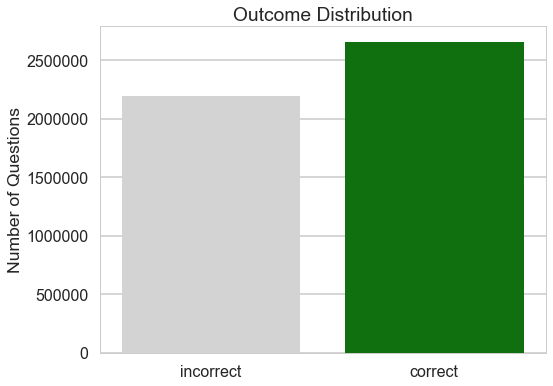

In [12]:
# Create bar plot for outcome distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x='outcome', palette=['lightgrey', 'green'])

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome Distribution');

---
### USER DATA

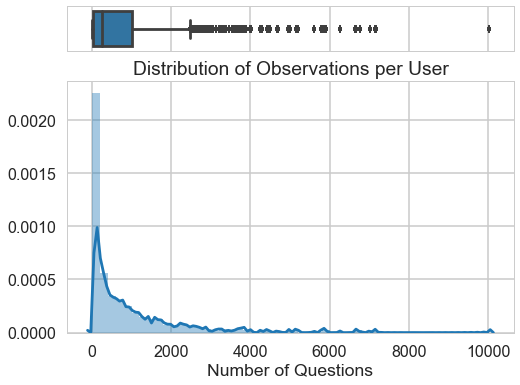

In [13]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(df.num_questions, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(df.num_questions, ax=histogram)

# Label axes and add title:
plt.xlabel('Number of Questions')
plt.title('Distribution of Observations per User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

As also indicated in the graph from the initial data exploration, it looks like a small percent of users attempted a large number of questions and a large percent attempted a small number of questions. Users attempting more than 4000 questions are scarce, but at least one attempted at least 10,000 questions.

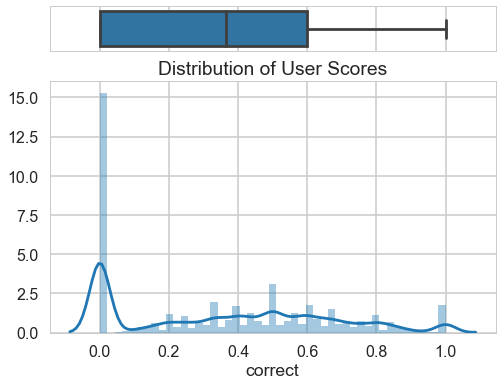

In [14]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(df.groupby('user_id').correct.mean(), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(df.groupby('user_id').correct.mean(), ax=histogram)

# Label axes and add title:
plt.title('Distribution of User Scores')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [15]:
atleast_30 = df.groupby('user_id').filter(lambda x: x['user_id'].count() >= 30)
len(atleast_30)

3783408

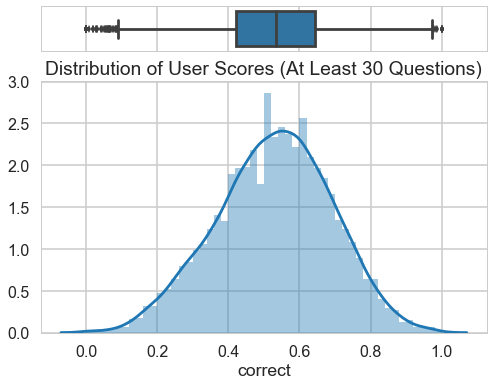

In [16]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(atleast_30.groupby('user_id').correct.mean(), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(atleast_30.groupby('user_id').correct.mean(), ax=histogram)

# Label axes and add title:
plt.title('Distribution of User Scores (At Least 30 Questions)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

---
### QUESTION DATA

In [17]:
# Print the number of unique question_id values:
print(('Number of Unique Questions:'), (len( df.question_id.unique() )))

Number of Unique Questions: 6045


In [18]:
# Count and save the number of questions per user:
observations_per_questionid = df.question_id.value_counts()

# Convert to a dataframe, reset the index for future plotting and drop resulting extra column:
observations_per_question = observations_per_questionid.to_frame('question_count').reset_index().drop('index', axis='columns')

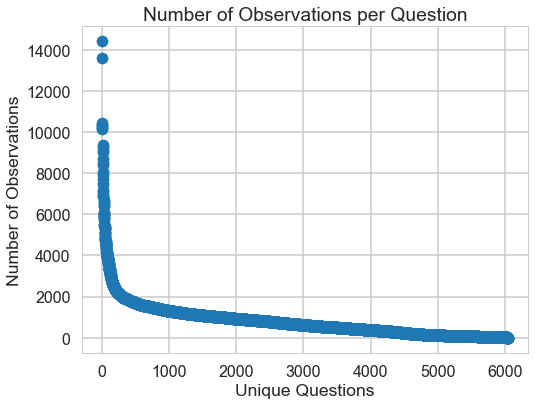

In [19]:
# Create questions_per_user scatter plot:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(observations_per_question.index, observations_per_question.question_count)

# Create the labels and title of the plot:
plt.xlabel('Unique Questions')
plt.ylabel('Number of Observations')
plt.title('Number of Observations per Question');

There are a large number of questions underrepresented in the dataset. Perhaps the question groups explain this. First, a look at prior attempts to answer a unique question.

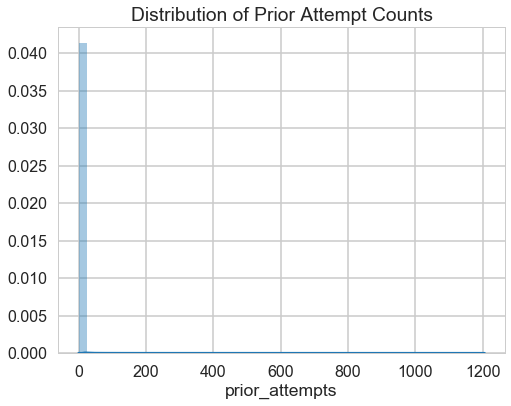

In [20]:
# Create a figure with two plots:
fig, ax = plt.subplots(figsize=(8, 6))
 
# Add histogram for correct_ratio:
sns.distplot(df.prior_attempts)

# Label axes and add title:
plt.title('Distribution of Prior Attempt Counts');

In [21]:
df[df.excessive_attempts == True].user_id.value_counts()

62044     1268
129150     274
3478       260
97572      212
27429      178
51964      170
134049     140
28257      132
114834      90
152666      64
26406       39
102545      32
95483       15
Name: user_id, dtype: int64

Some users had a ridiculous number of prior attempts. Surely only a bot would try to answer a question 1200+ times!?

In [22]:
df[df.user_id == 62044]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts,outcome
2945555,62044,2009-12-01 02:11:22,2009-12-01 02:13:16,2009-12-01 02:13:16,2009-12-01 02:13:16,0,5675,sat,6,15,5 13 83 215 257 261,1,7,1,00:01:54,0,0,1795,0,0,0,0,incorrect
2945556,62044,2009-12-01 02:13:34,2009-12-01 02:15:13,2009-12-01 02:15:13,2009-12-01 02:15:13,0,1859,sat,6,7,5 80 131 269 279,0,7,1,00:01:39,0,0,1795,0,0,0,0,incorrect
2945557,62044,2009-12-01 02:15:47,2009-12-01 02:18:27,2009-12-01 02:18:27,2009-12-01 02:18:27,0,2212,sat,6,7,83 131 169 215 279,0,7,1,00:02:40,0,0,1795,0,0,0,0,incorrect
2945558,62044,2009-12-01 02:18:36,2009-12-01 02:19:41,2009-12-01 02:19:42,2009-12-01 02:19:41,0,855,sat,6,7,5 88 131,0,7,1,00:01:05,0,0,1795,0,0,0,0,incorrect
2945559,62044,2009-12-01 02:19:52,NaT,2009-12-01 02:19:55,2009-12-01 02:19:55,0,197,sat,6,7,15 78 131 137 204 279,0,7,1,00:00:03,1,0,1795,0,0,0,0,incorrect
2945560,62044,2009-12-03 01:08:02,2009-12-03 01:11:03,2009-12-03 01:11:03,2009-12-03 01:11:03,0,5516,sat,6,7,15 78 121 131 137 204 279,0,7,1,00:03:01,0,0,1795,0,0,0,0,incorrect
2945561,62044,2009-12-03 01:11:09,2009-12-03 01:12:22,2009-12-03 01:12:22,2009-12-03 01:12:22,1,1296,sat,6,7,5 83 131 215 279,0,7,1,00:01:13,0,0,1795,0,0,0,0,correct
2945562,62044,2009-12-03 01:12:46,2009-12-03 01:14:55,2009-12-03 01:14:55,2009-12-03 01:14:55,0,5623,sat,6,15,5 71 138 261,1,7,1,00:02:09,0,0,1795,0,0,0,0,incorrect
2945563,62044,2009-12-03 01:15:39,2009-12-03 01:17:02,2009-12-03 01:17:02,2009-12-03 01:17:02,0,3291,sat,6,7,80 131 137 170 270,0,7,1,00:01:23,0,0,1795,0,0,0,0,incorrect
2945564,62044,2009-12-03 01:17:19,2009-12-03 01:20:29,2009-12-03 01:20:29,2009-12-03 01:20:29,0,204,sat,6,7,121 131 136 137 279,0,7,1,00:03:10,0,0,1795,0,0,0,0,incorrect


The records displayed indicate that the user's `excessive_attempts` rounds were all fast and sucessful. A number of the records don't seem so unusual though. Maybe a look at this user's 'normal' rounds will help.

In [23]:
df[(df.user_id == 62044) & (df.excessive_attempts == False) & (df.fast == False)]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts,outcome
2945555,62044,2009-12-01 02:11:22,2009-12-01 02:13:16,2009-12-01 02:13:16,2009-12-01 02:13:16,0,5675,sat,6,15,5 13 83 215 257 261,1,7,1,00:01:54,0,0,1795,0,0,0,0,incorrect
2945556,62044,2009-12-01 02:13:34,2009-12-01 02:15:13,2009-12-01 02:15:13,2009-12-01 02:15:13,0,1859,sat,6,7,5 80 131 269 279,0,7,1,00:01:39,0,0,1795,0,0,0,0,incorrect
2945557,62044,2009-12-01 02:15:47,2009-12-01 02:18:27,2009-12-01 02:18:27,2009-12-01 02:18:27,0,2212,sat,6,7,83 131 169 215 279,0,7,1,00:02:40,0,0,1795,0,0,0,0,incorrect
2945558,62044,2009-12-01 02:18:36,2009-12-01 02:19:41,2009-12-01 02:19:42,2009-12-01 02:19:41,0,855,sat,6,7,5 88 131,0,7,1,00:01:05,0,0,1795,0,0,0,0,incorrect
2945560,62044,2009-12-03 01:08:02,2009-12-03 01:11:03,2009-12-03 01:11:03,2009-12-03 01:11:03,0,5516,sat,6,7,15 78 121 131 137 204 279,0,7,1,00:03:01,0,0,1795,0,0,0,0,incorrect
2945561,62044,2009-12-03 01:11:09,2009-12-03 01:12:22,2009-12-03 01:12:22,2009-12-03 01:12:22,1,1296,sat,6,7,5 83 131 215 279,0,7,1,00:01:13,0,0,1795,0,0,0,0,correct
2945562,62044,2009-12-03 01:12:46,2009-12-03 01:14:55,2009-12-03 01:14:55,2009-12-03 01:14:55,0,5623,sat,6,15,5 71 138 261,1,7,1,00:02:09,0,0,1795,0,0,0,0,incorrect
2945563,62044,2009-12-03 01:15:39,2009-12-03 01:17:02,2009-12-03 01:17:02,2009-12-03 01:17:02,0,3291,sat,6,7,80 131 137 170 270,0,7,1,00:01:23,0,0,1795,0,0,0,0,incorrect
2945564,62044,2009-12-03 01:17:19,2009-12-03 01:20:29,2009-12-03 01:20:29,2009-12-03 01:20:29,0,204,sat,6,7,121 131 136 137 279,0,7,1,00:03:10,0,0,1795,0,0,0,0,incorrect
2945565,62044,2009-12-03 01:22:54,2009-12-03 01:23:42,2009-12-03 01:23:42,2009-12-03 01:23:42,1,3875,sat,6,7,83 119 131 154,0,7,1,00:00:48,0,0,1795,0,0,0,0,correct


There are only 246 of the user's 1795 records which cannot be described by excessive prior attempts or as a fast round. Prior attempts for many of the observations above are still numerous, if not arbitrarily defined as excessive.

In [24]:
246/1795

0.1370473537604457

In [25]:
df[df.user_id == 62044].describe()

,user_id,correct,question_id,track_name,subtrack_name,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts
count,1795.0,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000,1795,1795.000000,1795.0,1795.0,1795.0,1795.0,1795.000000,1795.000000
mean,62044.0,0.933705,2469.242340,6.037883,7.148189,0.023955,4.291365,1.197772,0 days 00:00:19.157660,0.836212,0.0,1795.0,0.0,0.0,423.260167,0.706407
std,0.0,0.248867,694.014035,0.264411,1.291552,0.152953,0.919447,0.768960,0 days 00:00:52.210813,0.370186,0.0,0.0,0.0,0.0,385.352360,0.455535
min,62044.0,0.000000,33.000000,6.000000,3.000000,0.000000,1.000000,1.000000,0 days 00:00:01,0.000000,0.0,1795.0,0.0,0.0,0.000000,0.000000
25%,62044.0,1.000000,2274.000000,6.000000,7.000000,0.000000,4.000000,1.000000,0 days 00:00:01,1.000000,0.0,1795.0,0.0,0.0,74.500000,0.000000
50%,62044.0,1.000000,2476.000000,6.000000,7.000000,0.000000,4.000000,1.000000,0 days 00:00:01,1.000000,0.0,1795.0,0.0,0.0,308.000000,1.000000
75%,62044.0,1.000000,2476.000000,6.000000,7.000000,0.000000,4.000000,1.000000,0 days 00:00:02,1.000000,0.0,1795.0,0.0,0.0,756.500000,1.000000
max,62044.0,1.000000,6032.000000,8.000000,15.000000,1.000000,7.000000,8.000000,0 days 00:04:01,1.000000,0.0,1795.0,0.0,0.0,1205.000000,1.000000


In [26]:
df[(df.user_id == 62044) & (df.excessive_attempts == True)].describe()

,user_id,correct,question_id,track_name,subtrack_name,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts
count,1268.0,1268.000000,1268.000000,1268.0,1268.0,1268.0,1268.0,1268.000000,1268,1268.000000,1268.0,1268.0,1268.0,1268.0,1268.000000,1268.0
mean,62044.0,0.995268,2422.324132,6.0,7.0,0.0,4.0,1.003943,0 days 00:00:01.815457,0.962145,0.0,1795.0,0.0,0.0,587.215300,1.0
std,0.0,0.068653,150.391459,0.0,0.0,0.0,0.0,0.062696,0 days 00:00:02.896370,0.190921,0.0,0.0,0.0,0.0,343.764225,0.0
min,62044.0,0.000000,1903.000000,6.0,7.0,0.0,4.0,1.000000,0 days 00:00:01,0.000000,0.0,1795.0,0.0,0.0,101.000000,1.0
25%,62044.0,1.000000,2476.000000,6.0,7.0,0.0,4.0,1.000000,0 days 00:00:01,1.000000,0.0,1795.0,0.0,0.0,254.750000,1.0
50%,62044.0,1.000000,2476.000000,6.0,7.0,0.0,4.0,1.000000,0 days 00:00:01,1.000000,0.0,1795.0,0.0,0.0,571.500000,1.0
75%,62044.0,1.000000,2476.000000,6.0,7.0,0.0,4.0,1.000000,0 days 00:00:02,1.000000,0.0,1795.0,0.0,0.0,888.250000,1.0
max,62044.0,1.000000,2476.000000,6.0,7.0,0.0,4.0,2.000000,0 days 00:00:49,1.000000,0.0,1795.0,0.0,0.0,1205.000000,1.0


In [27]:
df[(df.user_id == 62044) & (df.excessive_attempts == False)].describe()

,user_id,correct,question_id,track_name,subtrack_name,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts
count,527.0,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527,527.000000,527.0,527.0,527.0,527.0,527.000000,527.0
mean,62044.0,0.785579,2582.130930,6.129032,7.504744,0.081594,4.992410,1.664137,0 days 00:01:00.884250,0.533207,0.0,1795.0,0.0,0.0,28.772296,0.0
std,0.0,0.410810,1253.076954,0.476094,2.347128,0.274005,1.478599,1.303368,0 days 00:01:22.508692,0.499370,0.0,0.0,0.0,0.0,33.171655,0.0
min,62044.0,0.000000,33.000000,6.000000,3.000000,0.000000,1.000000,1.000000,0 days 00:00:01,0.000000,0.0,1795.0,0.0,0.0,0.000000,0.0
25%,62044.0,1.000000,1903.000000,6.000000,7.000000,0.000000,4.000000,1.000000,0 days 00:00:02,0.000000,0.0,1795.0,0.0,0.0,0.000000,0.0
50%,62044.0,1.000000,2212.000000,6.000000,7.000000,0.000000,4.000000,1.000000,0 days 00:00:03,1.000000,0.0,1795.0,0.0,0.0,13.000000,0.0
75%,62044.0,1.000000,2495.000000,6.000000,7.000000,0.000000,7.000000,2.000000,0 days 00:01:55,1.000000,0.0,1795.0,0.0,0.0,56.500000,0.0
max,62044.0,1.000000,6032.000000,8.000000,15.000000,1.000000,7.000000,8.000000,0 days 00:04:01,1.000000,0.0,1795.0,0.0,0.0,100.000000,0.0


In [28]:
df[(df.user_id == 62044) & (df.fast == True)].describe()

,user_id,correct,question_id,track_name,subtrack_name,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts
count,1501.0,1501.000000,1501.000000,1501.000000,1501.000000,1501.0,1501.000000,1501.000000,1501,1501.0,1501.0,1501.0,1501.0,1501.0,1501.000000,1501.000000
mean,62044.0,0.989340,2377.164557,6.013324,6.980680,0.0,4.008661,1.000666,0 days 00:00:01.540972,1.0,0.0,1795.0,0.0,0.0,488.678215,0.812791
std,0.0,0.102728,230.459585,0.162754,0.245547,0.0,0.112212,0.025811,0 days 00:00:00.808591,0.0,0.0,0.0,0.0,0.0,376.126117,0.390209
min,62044.0,0.000000,197.000000,6.000000,3.000000,0.0,4.000000,1.000000,0 days 00:00:01,1.0,0.0,1795.0,0.0,0.0,0.000000,0.000000
25%,62044.0,1.000000,2476.000000,6.000000,7.000000,0.0,4.000000,1.000000,0 days 00:00:01,1.0,0.0,1795.0,0.0,0.0,132.000000,1.000000
50%,62044.0,1.000000,2476.000000,6.000000,7.000000,0.0,4.000000,1.000000,0 days 00:00:01,1.0,0.0,1795.0,0.0,0.0,428.000000,1.000000
75%,62044.0,1.000000,2476.000000,6.000000,7.000000,0.0,4.000000,1.000000,0 days 00:00:02,1.0,0.0,1795.0,0.0,0.0,819.000000,1.000000
max,62044.0,1.000000,4830.000000,8.000000,7.000000,0.0,7.000000,2.000000,0 days 00:00:04,1.0,0.0,1795.0,0.0,0.0,1205.000000,1.000000


In [29]:
df[(df.user_id == 62044) & (df.fast == False)].describe()

,user_id,correct,question_id,track_name,subtrack_name,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts
count,294.0,294.00000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294,294.0,294.0,294.0,294.0,294.0,294.000000,294.000000
mean,62044.0,0.64966,2939.340136,6.163265,8.003401,0.146259,5.734694,2.204082,0 days 00:01:49.098639,0.0,0.0,1795.0,0.0,0.0,89.272109,0.163265
std,0.0,0.47789,1553.071292,0.523063,3.004545,0.353968,1.616158,1.549805,0 days 00:01:23.549624,0.0,0.0,0.0,0.0,0.0,226.093492,0.370238
min,62044.0,0.00000,33.000000,6.000000,3.000000,0.000000,1.000000,1.000000,0 days 00:00:05,0.0,0.0,1795.0,0.0,0.0,0.000000,0.000000
25%,62044.0,0.00000,1928.250000,6.000000,7.000000,0.000000,4.000000,1.000000,0 days 00:00:19.750000,0.0,0.0,1795.0,0.0,0.0,0.000000,0.000000
50%,62044.0,1.00000,2476.000000,6.000000,7.000000,0.000000,7.000000,1.000000,0 days 00:01:41.500000,0.0,0.0,1795.0,0.0,0.0,0.000000,0.000000
75%,62044.0,1.00000,4021.750000,6.000000,7.000000,0.000000,7.000000,3.000000,0 days 00:03:03.750000,0.0,0.0,1795.0,0.0,0.0,2.000000,0.000000
max,62044.0,1.00000,6032.000000,8.000000,15.000000,1.000000,7.000000,8.000000,0 days 00:04:01,0.0,0.0,1795.0,0.0,0.0,1119.000000,1.000000


In [30]:
df[(df.user_id == 62044) & (df.excessive_attempts == True) & (df.fast == True)].describe()

,user_id,correct,question_id,track_name,subtrack_name,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts
count,1220.0,1220.000000,1220.000000,1220.0,1220.0,1220.0,1220.0,1220.00000,1220,1220.0,1220.0,1220.0,1220.0,1220.0,1220.000000,1220.0
mean,62044.0,0.995902,2420.212295,6.0,7.0,0.0,4.0,1.00082,0 days 00:00:01.478688,1.0,0.0,1795.0,0.0,0.0,589.240984,1.0
std,0.0,0.063913,152.938819,0.0,0.0,0.0,0.0,0.02863,0 days 00:00:00.801171,0.0,0.0,0.0,0.0,0.0,346.155547,0.0
min,62044.0,0.000000,1903.000000,6.0,7.0,0.0,4.0,1.00000,0 days 00:00:01,1.0,0.0,1795.0,0.0,0.0,101.000000,1.0
25%,62044.0,1.000000,2476.000000,6.0,7.0,0.0,4.0,1.00000,0 days 00:00:01,1.0,0.0,1795.0,0.0,0.0,243.750000,1.0
50%,62044.0,1.000000,2476.000000,6.0,7.0,0.0,4.0,1.00000,0 days 00:00:01,1.0,0.0,1795.0,0.0,0.0,581.500000,1.0
75%,62044.0,1.000000,2476.000000,6.0,7.0,0.0,4.0,1.00000,0 days 00:00:02,1.0,0.0,1795.0,0.0,0.0,894.250000,1.0
max,62044.0,1.000000,2476.000000,6.0,7.0,0.0,4.0,2.00000,0 days 00:00:04,1.0,0.0,1795.0,0.0,0.0,1205.000000,1.0


In [31]:
df[(df.user_id == 62044) & (df.excessive_attempts == False) & (df.fast == False)].describe()

,user_id,correct,question_id,track_name,subtrack_name,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts
count,246.0,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246,246.0,246.0,246.0,246.0,246.0,246.000000,246.0
mean,62044.0,0.585366,3029.747967,6.195122,8.199187,0.174797,6.073171,2.422764,0 days 00:02:08.361788,0.0,0.0,1795.0,0.0,0.0,2.158537,0.0
std,0.0,0.493663,1683.545072,0.566530,3.249640,0.380567,1.555350,1.601062,0 days 00:01:17.722657,0.0,0.0,0.0,0.0,0.0,7.639537,0.0
min,62044.0,0.000000,33.000000,6.000000,3.000000,0.000000,1.000000,1.000000,0 days 00:00:05,0.0,0.0,1795.0,0.0,0.0,0.000000,0.0
25%,62044.0,0.000000,1860.250000,6.000000,7.000000,0.000000,5.000000,1.000000,0 days 00:01:01.250000,0.0,0.0,1795.0,0.0,0.0,0.000000,0.0
50%,62044.0,1.000000,2731.500000,6.000000,7.000000,0.000000,7.000000,2.000000,0 days 00:02:09.500000,0.0,0.0,1795.0,0.0,0.0,0.000000,0.0
75%,62044.0,1.000000,4508.250000,6.000000,7.000000,0.000000,7.000000,4.000000,0 days 00:03:18,0.0,0.0,1795.0,0.0,0.0,0.000000,0.0
max,62044.0,1.000000,6032.000000,8.000000,15.000000,1.000000,7.000000,8.000000,0 days 00:04:01,0.0,0.0,1795.0,0.0,0.0,67.000000,0.0


In [32]:
df[df.user_id == 62044].group_name.value_counts()

sat    1795
Name: group_name, dtype: int64

It's difficult to know what to do about this outlier. Some behavior seems to indicate a bot, but other activity may be legitimate. If not a bot, perhaps this user was just trying to game the score? This user practiced only in the SAT group, so maybe it will become more clear when taking a look at SAT only data.

### Groups and Other Question Categories

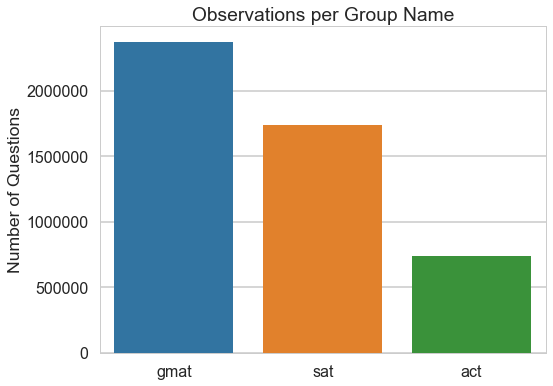

In [33]:
# Create bar plot for group_name distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="group_name")

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Observations per Group Name');

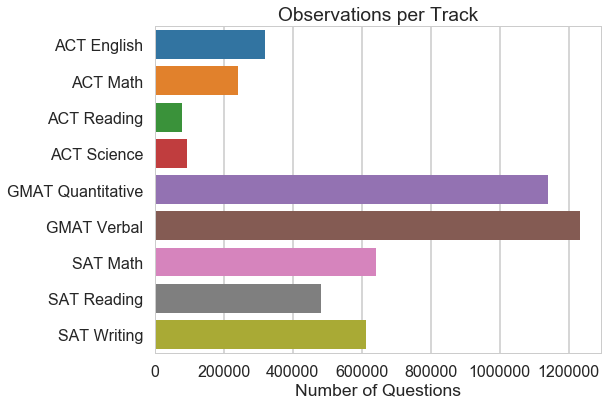

In [34]:
# Create bar plot for track_name distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, y='track_name')

# Create bar labels:
tracks = ('ACT English', 'ACT Math', 'ACT Reading', 'ACT Science', 'GMAT Quantitative', 
              'GMAT Verbal', 'SAT Math', 'SAT Reading', 'SAT Writing')
plt.yticks(np.arange(len(tracks)), tracks)

# Create axis labels and the title:
plt.xlabel('Number of Questions')
plt.ylabel('')
plt.title('Observations per Track');

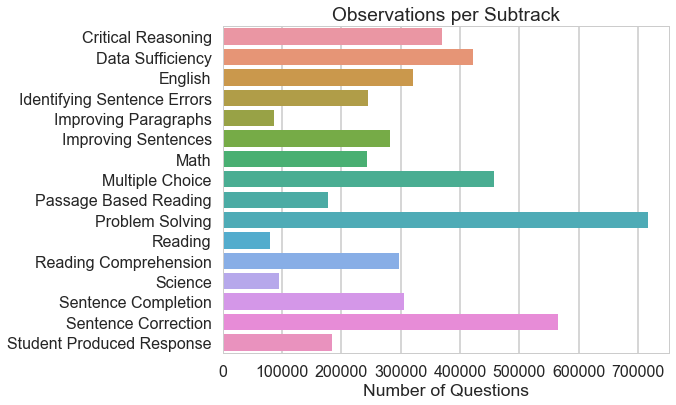

In [35]:
# Create bar plot for subtrack_name distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, y='subtrack_name')

# Create bar labels:
subtracks = ('Critical Reasoning', 'Data Sufficiency', 'English', 'Identifying Sentence Errors', 
             'Improving Paragraphs', 'Improving Sentences', 'Math', 'Multiple Choice', 
             'Passage Based Reading', 'Problem Solving', 'Reading', 'Reading Comprehension', 
             'Science', 'Sentence Completion', 'Sentence Correction', 'Student Produced Response')
plt.yticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('Number of Questions')
plt.ylabel('')
plt.title('Observations per Subtrack');

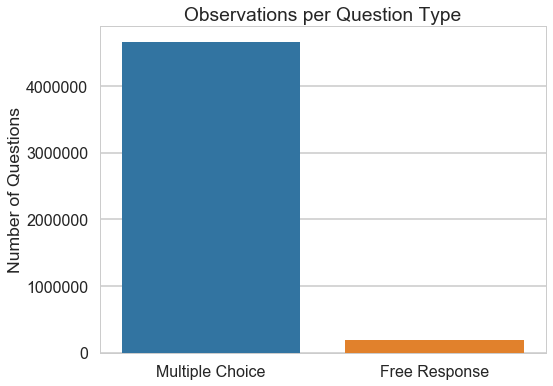

In [36]:
# Create bar plot for question_type distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x='question_type')

# Create bar labels:
plt.xticks(np.arange(2), ('Multiple Choice', 'Free Response'))

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Observations per Question Type');

In [37]:
df.question_type.value_counts()

0    4661934
1     184796
Name: question_type, dtype: int64

In [38]:
df[df.question_type == 1]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts,outcome
317,112161,2009-04-30 20:43:34,2009-04-30 20:44:29,2009-04-30 20:45:23,2009-04-30 20:44:29,0,994,sat,6,15,5 218 261,1,7,3,00:00:55,0,0,3,1,0,0,0,incorrect
330,28612,2010-02-20 01:33:03,2010-02-20 01:33:06,2010-02-20 01:33:06,2010-02-20 01:33:06,0,5180,sat,6,15,5 170 261 269 279,1,7,1,00:00:03,1,0,5,1,0,0,0,incorrect
378,71016,2010-11-17 01:40:32,2010-11-17 01:40:38,2010-11-17 01:40:40,2010-11-17 01:40:38,0,5878,sat,6,15,15 76 137 261 279,1,7,1,00:00:06,0,0,31,0,0,0,0,incorrect
2016,150602,2011-10-21 14:57:14,2011-10-21 14:58:27,2011-10-21 14:58:31,2011-10-21 14:58:27,1,261,sat,6,15,10 12 37 83 119 167 204 261 279,1,5,1,00:01:13,0,0,21,0,0,0,0,correct
2017,150602,2011-10-21 14:58:31,2011-10-21 15:00:14,2011-10-21 15:00:16,2011-10-21 15:00:14,1,5217,sat,6,15,19 119 159 170 249 261,1,5,1,00:01:43,0,0,21,0,0,0,0,correct
2018,150602,2011-10-21 15:00:16,2011-10-21 15:01:33,2011-10-21 15:01:35,2011-10-21 15:01:33,0,2863,sat,6,15,48 121 137 261 279,1,5,1,00:01:17,0,0,21,0,0,0,0,incorrect
2019,150602,2011-10-21 15:01:35,2011-10-21 15:04:31,2011-10-21 15:04:34,2011-10-21 15:04:31,0,5293,sat,6,15,13 83 169 204 261,1,5,1,00:02:56,0,0,21,0,0,0,0,incorrect
2022,150602,2011-10-21 15:07:16,2011-10-21 15:10:02,2011-10-21 15:10:05,2011-10-21 15:10:02,0,1612,sat,6,15,53 78 137 147 204 261 279,1,5,1,00:02:46,0,0,21,0,0,0,0,incorrect
2023,150602,2011-10-21 15:10:05,2011-10-21 15:12:01,2011-10-21 15:12:03,2011-10-21 15:12:01,0,5623,sat,6,15,5 71 138 261,1,5,1,00:01:56,0,0,21,0,0,0,0,incorrect
2026,150602,2011-10-21 15:40:24,2011-10-21 15:41:07,2011-10-21 15:41:09,2011-10-21 15:41:07,1,721,sat,6,15,5 13 83 150 175 261,1,4,1,00:00:43,0,0,21,0,0,0,0,correct


In [39]:
df[df.question_type == 1].group_name.value_counts()

sat    184796
Name: group_name, dtype: int64

In [40]:
df[df.question_type == 1].subtrack_name.value_counts()

15    184796
Name: subtrack_name, dtype: int64

Inclination was to drop the `question_type` category since most observations are multiple choice, but free response questions belong only to the SAT group, so it could be eliminated for the other two. The only subtrack associated with Free Response is Student Produced Response, which makes sense and could be informative.

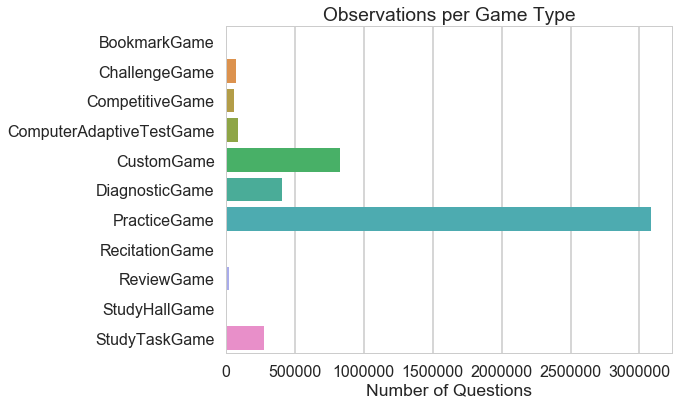

In [41]:
# Create bar plot for game_type distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, y='game_type')

# Create bar labels:
game_types = ('BookmarkGame', 'ChallengeGame', 'CompetitiveGame', 'ComputerAdaptiveTestGame', 
              'CustomGame', 'DiagnosticGame', 'PracticeGame', 'RecitationGame', 
              'ReviewGame', 'StudyHallGame', 'StudyTaskGame')
plt.yticks(np.arange(len(game_types)), game_types)

# Create axis labels and the title:
plt.xlabel('Number of Questions')
plt.ylabel('')
plt.title('Observations per Game Type');

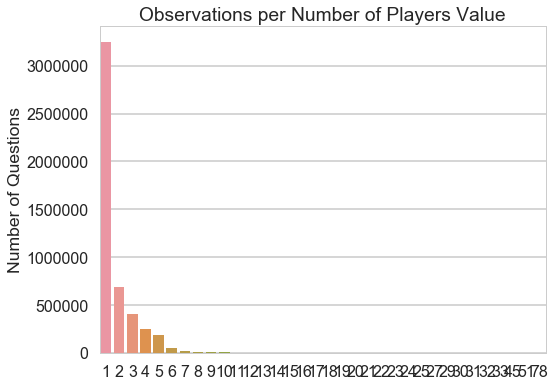

In [42]:
# Create bar plot for num_players distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x='num_players')

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Observations per Number of Players Value');

Intuition and some of the graphs above suggest the test groups are independent.

## Investigate Overlap of Test Groups

In [43]:
# Get a view of tiered variables related to question groups:
group_tracks = pd.crosstab(index=df.subtrack_name,columns=[df.group_name, df.track_name])
group_tracks

group_name        act                          gmat             sat          \
track_name          0       1      2      3       4       5       6       7   
subtrack_name                                                                 
0                   0       0      0      0       0  368856       0       0   
1                   0       0      0      0  422357       0       0       0   
2              320223       0      0      0       0       0       0       0   
3                   0       0      0      0       0       0       0       0   
4                   0       0      0      0       0       0       0       0   
5                   0       0      0      0       0       0       0       0   
6                   0  242967      0      0       0       0       0       0   
7                   0       0      0      0       0       0  456716       0   
8                   0       0      0      0       0       0       0  178051   
9                   0       0      0      0  717200       0       0       0   
10                  0       0  78771      0       0       0       0       0   
11                  0       0      0      0       0  297284       0       0   
12                  0       0      0  94736       0       0       0       0   
13                  0       0      0      0       0       0       0  305381   
14                  0       0      0      0       0  565691       0       0   
15                  0       0      0      0       0       0  184796       0   

group_name             
track_name          8  
subtrack_name          
0                   0  
1                   0  
2                   0  
3              245322  
4               86282  
5              282097  
6                   0  
7                   0  
8                   0  
9                   0  
10                  0  
11                  0  
12                  0  
13                  0  
14                  0  
15                  0

This confirms that there is no overlap in the tracks or subtracks across groups. There is only one subtrack for each ACT track, so either variable will be fine to explore or drop.

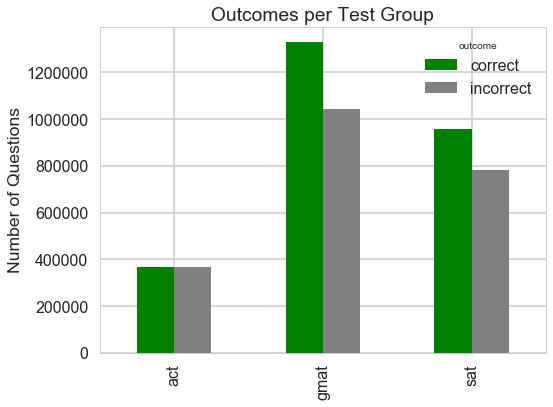

In [44]:
# Get a broad quick view of outcome by group name:
pd.crosstab(index=df.group_name, columns=[df.outcome]).plot(kind='bar', color=('green', 'grey'), stacked=False, figsize=(8, 6))

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcomes per Test Group');

Are GMAT and SAT easier to master or does this just fall in line with the intuition that more practice means better success? And is that mischievous user's data enough to skew the SAT results?

## Divide the Dataframe

In [45]:
# Drop selected columns and save results:
df2 = df.drop(['num_questions', 'few', 'many'], axis=1)

In [46]:
def user_stats(df):
    
    # Save the total number of entries per user in the 'correct' column:
    num_questions = df.groupby('user_id')['correct'].count()

    # Save the total number of correct entries per user in the 'correct' column;
    # values are 0 (incorrect) and 1 (correct), so a sum of values in the column will do:
    num_correct = df.groupby('user_id')['correct'].sum()

    # Save the total number of incorrect entries per user by subracting correct from total:
    num_incorrect = num_questions.subtract(num_correct)

    # Save the ratio of correct answers per user, dividing by total:
    correct_ratio = num_correct/num_questions


    # Get and save the sum of each user's round duration:
    total_practice = df.groupby('user_id')['round_duration'].sum()

    # Calculate and save the mean round duration per user:
    round_duration_avg = total_practice/num_questions


    # Build and save the dictionary to look at user data:
    new_data = {
        'num_questions': num_questions,
        'num_correct': num_correct,
        'num_incorrect': num_incorrect,
        'correct_ratio': correct_ratio,
        'total_practice': total_practice,
        'round_duration_avg': round_duration_avg
    }

    # Build dataframe from new_data dictionary:
    user_stats = pd.DataFrame(new_data)


    user_stats['few'] = np.where(user_stats.num_questions < 6, 1, 0)
    user_stats['many'] = np.where(user_stats.num_questions > 4000, 1, 0)

    user_stats['fast_avg'] = np.where(user_stats.round_duration_avg < '5seconds', 1, 0)
    user_stats['slow_avg'] = np.where(user_stats.round_duration_avg > '10minutes', 1, 0)

    # Reorder the columns:
    user_stats = user_stats[['num_correct', 'num_incorrect', 'num_questions', 'few', 'many', 'correct_ratio', 'total_practice', 'round_duration_avg', 'slow_avg', 'fast_avg']]

    data = user_stats.reset_index(drop=False)
    data = data.rename(columns = {'index':'user_id'})
    

    df = pd.merge(df, data, on='user_id', how='inner')
    
    return df, user_stats

In [47]:
def cdf(data):
    """Compute CDF for a one-dimensional array of measurements."""

    # Number of data points:
    n = len(data)

    # x-data for the CDF:
    x = np.sort(data)

    # y-data for the CDF:
    y = np.arange(1, n+1) / n

    return x, y

In [48]:
# Save and inspect a dataframe of observations for the ACT group only:
act = df2[df2['group_name'] == 'act']
act, act_users = user_stats(act)
act.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
0,121052,2011-11-10 18:32:18,2011-11-10 18:32:44,2011-11-10 18:33:21,2011-11-10 18:32:44,1,3010,act,3,12,22 51 56 61 114 243,0,7,3,00:00:26,0,0,0,0,correct,6,0,6,0,0,1.0,00:03:20,00:00:33.333333,0,0
1,121052,2011-11-10 18:34:49,2011-11-10 18:35:45,2011-11-10 18:35:47,2011-11-10 18:35:45,1,4446,act,3,12,16 22 50 51 123 243,0,7,2,00:00:56,0,0,0,0,correct,6,0,6,0,0,1.0,00:03:20,00:00:33.333333,0,0
2,121052,2011-11-10 18:36:03,2011-11-10 18:36:50,2011-11-10 18:37:06,2011-11-10 18:36:50,1,1488,act,3,12,34 51 61 114 123 146 152 243,0,7,2,00:00:47,0,0,0,0,correct,6,0,6,0,0,1.0,00:03:20,00:00:33.333333,0,0
3,121052,2011-11-10 18:37:15,2011-11-10 18:37:31,2011-11-10 18:37:45,2011-11-10 18:37:31,1,787,act,3,12,6 34 50 51 102 114 152 243,0,7,2,00:00:16,0,0,0,0,correct,6,0,6,0,0,1.0,00:03:20,00:00:33.333333,0,0
4,121052,2011-11-10 18:37:50,2011-11-10 18:38:15,2011-11-10 18:38:17,2011-11-10 18:38:15,1,2526,act,3,12,34 50 152 162 212 243,0,7,2,00:00:25,0,0,0,0,correct,6,0,6,0,0,1.0,00:03:20,00:00:33.333333,0,0


In [49]:
# Save and inspect a dataframe of observations for the GMAT group only:
gmat = df2[df2['group_name'] == 'gmat']
gmat, gmat_users = user_stats(gmat)
gmat.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,0,5560,gmat,5,14,222 233 240 246,0,7,1,00:01:05,0,0,0,0,incorrect,169,146,315,0,0,0.536508,07:42:42,00:01:28.133333,0,0
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,1,4681,gmat,5,0,24 49,0,7,1,00:01:22,0,0,0,0,correct,169,146,315,0,0,0.536508,07:42:42,00:01:28.133333,0,0
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,1,1529,gmat,5,0,31 49,0,7,1,00:01:14,0,0,0,0,correct,169,146,315,0,0,0.536508,07:42:42,00:01:28.133333,0,0
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,1,2908,gmat,5,0,31 49,0,7,1,00:01:02,0,0,0,0,correct,169,146,315,0,0,0.536508,07:42:42,00:01:28.133333,0,0
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,1,1773,gmat,5,11,183 194 207,0,7,1,00:02:57,0,0,0,0,correct,169,146,315,0,0,0.536508,07:42:42,00:01:28.133333,0,0


In [50]:
# Save and inspect a dataframe of observations for the SAT group only:
sat = df2[df2['group_name'] == 'sat']
sat, sat_users = user_stats(sat)
sat.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
0,112161,2009-04-30 20:41:56,2009-04-30 20:42:37,2009-04-30 20:42:37,2009-04-30 20:42:37,1,4814,sat,6,7,83 131 150 169 215 257 279,0,7,1,00:00:41,0,0,0,0,correct,2,1,3,1,0,0.666667,00:02:05,00:00:41.666666,0,0
1,112161,2009-04-30 20:42:50,2009-04-30 20:43:19,2009-04-30 20:43:21,2009-04-30 20:43:19,1,2884,sat,6,7,53 131 159,0,7,2,00:00:29,0,0,0,0,correct,2,1,3,1,0,0.666667,00:02:05,00:00:41.666666,0,0
2,112161,2009-04-30 20:43:34,2009-04-30 20:44:29,2009-04-30 20:45:23,2009-04-30 20:44:29,0,994,sat,6,15,5 218 261,1,7,3,00:00:55,0,0,0,0,incorrect,2,1,3,1,0,0.666667,00:02:05,00:00:41.666666,0,0
3,154786,2011-05-27 17:04:44,2011-05-27 17:06:24,2011-05-27 17:08:44,2011-05-27 17:06:24,0,5706,sat,6,7,53 131 137 159 279,0,7,2,00:01:40,0,0,0,0,incorrect,2,2,4,1,0,0.500000,00:04:39,00:01:09.750000,0,0
4,154786,2011-05-27 17:10:59,2011-05-27 17:11:43,2011-05-27 17:11:47,2011-05-27 17:11:43,1,225,sat,6,7,5 131 138,0,7,1,00:00:44,0,0,0,0,correct,2,2,4,1,0,0.500000,00:04:39,00:01:09.750000,0,0


### Overlap of Other Variables across Test Groups

#### USERS
---

In [51]:
act_unique_users = set(act.user_id)
print('Number of Users Preparing for ACT:', len(act_unique_users))

gmat_unique_users = set(gmat.user_id)
print('Number of Users Preparing for GMAT:', len(gmat_unique_users))

sat_unique_users = set(sat.user_id)
print('Number of Users Preparing for SAT:', len(sat_unique_users))

Number of Users Preparing for ACT: 38518
Number of Users Preparing for GMAT: 78488
Number of Users Preparing for SAT: 64834


In [52]:
print('Number of Users Preparing for All Test Groups:', len(act_unique_users.intersection(gmat_unique_users, sat_unique_users)))
print('Number of Users Preparing for ACT & GMAT:', len(act_unique_users.intersection(gmat_unique_users)))
print('Number of Users Preparing for ACT & SAT:', len(act_unique_users.intersection(sat_unique_users)))
print('Number of Users Preparing for GMAT & SAT:', len(gmat_unique_users.intersection(sat_unique_users)))

Number of Users Preparing for All Test Groups: 228
Number of Users Preparing for ACT & GMAT: 377
Number of Users Preparing for ACT & SAT: 1638
Number of Users Preparing for GMAT & SAT: 1020


#### UNIQUE QUESTIONS
---

In [53]:
act_unique_questions = set(act.question_id)
print('Number of Unique Questions in the ACT Group:', len(act_unique_questions))

gmat_unique_questions = set(gmat.question_id)
print('Number of Unique Questions in the GMAT Group:', len(gmat_unique_questions))

sat_unique_questions = set(sat.question_id)
print('Number of Unique Questions in the SAT Group:', len(sat_unique_questions))

Number of Unique Questions in the ACT Group: 2094
Number of Unique Questions in the GMAT Group: 2203
Number of Unique Questions in the SAT Group: 1748


In [54]:
print('Number of Unique Questions in All Test Groups:', len(act_unique_questions.intersection(gmat_unique_questions, sat_unique_questions)))
print('Number of Unique Questions in the ACT & GMAT Test Groups:', len(act_unique_questions.intersection(gmat_unique_questions)))
print('Number of Unique Questions in the ACT & SAT Test Groups:', len(act_unique_questions.intersection(sat_unique_questions)))
print('Number of Unique Questions in the GMAT & SAT Test Groups:', len(gmat_unique_questions.intersection(sat_unique_questions)))

Number of Unique Questions in All Test Groups: 0
Number of Unique Questions in the ACT & GMAT Test Groups: 0
Number of Unique Questions in the ACT & SAT Test Groups: 0
Number of Unique Questions in the GMAT & SAT Test Groups: 0


Unique values for each group name: 2094 + 2203 + 1748 = 6045

---
## ACT EDA

In [55]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    act[column] = act[column].astype('category')

# Convert ordered categorical variables:
act['num_players'] = pd.Categorical(act['num_players'], ordered=True)
act['prior_attempts'] = pd.Categorical(act['prior_attempts'], ordered=True)

In [56]:
print('Group name counts associated with excessive prior attempts:')
act[act.excessive_attempts == True].group_name.value_counts()

Group name counts associated with excessive prior attempts:


act    0
Name: group_name, dtype: int64

## All Observations (ACT)

In [57]:
# Display statistics for numerical variables:
act.describe()

,correct,round_duration,num_correct,num_incorrect,num_questions,correct_ratio,total_practice,round_duration_avg
count,736697.000000,736697,736697.000000,736697.000000,736697.000000,736697.000000,736697,736697
mean,0.500982,0 days 00:00:53.109867,150.993183,122.193271,273.186454,0.500982,0 days 03:42:10.424261,0 days 00:00:53.109867
std,0.499999,0 days 00:05:31.306196,365.151758,276.460689,623.009494,0.196787,0 days 08:30:10.813180,0 days 00:05:22.732728
min,0.000000,0 days 00:00:01,0.000000,0.000000,1.000000,0.000000,0 days 00:00:01,0 days 00:00:01
25%,0.000000,0 days 00:00:19,9.000000,9.000000,19.000000,0.375000,0 days 00:14:44,0 days 00:00:35.148648
50%,1.000000,0 days 00:00:36,32.000000,31.000000,66.000000,0.516129,0 days 00:49:24,0 days 00:00:48.424242
75%,1.000000,0 days 00:01:07,123.000000,105.000000,234.000000,0.639085,0 days 03:04:25,0 days 00:01:03.831615
max,1.000000,3 days 04:29:45,2911.000000,2298.000000,5209.000000,1.000000,3 days 04:29:45,3 days 04:29:45


In [58]:
# Filter columns for category datatype and display the statistics:
categorical = act.dtypes[act.dtypes == 'category'].index
act[categorical].describe()

,user_id,question_id,group_name,track_name,subtrack_name,question_type,game_type,num_players,fast,slow,prior_attempts,excessive_attempts,outcome,few,many,slow_avg,fast_avg
count,736697,736697,736697,736697,736697,736697,736697,736697,736697,736697,736697,736697,736697,736697,736697,736697,736697
unique,38518,2094,1,4,4,1,10,25,2,2,42,1,2,2,2,2,2
top,132295,5813,act,0,2,0,7,1,0,0,0,0,correct,0,0,0,0
freq,5209,7492,736697,320223,320223,736697,562789,566185,696984,736182,688641,736697,369072,696834,731488,736596,732866


## At least 30 Questions per User (ACT)

In [59]:
# Save and inspect a dataframe of observations for the ACT group only:
act2 = df2[df2['group_name'] == 'act']
act_30 = act2.groupby('user_id').filter(lambda x: x['user_id'].count() >= 30)
act_30, act_users_30 = user_stats(act_30)
act_30.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
0,130429,2010-10-21 17:16:52,NaT,2010-10-21 17:18:01,2010-10-21 17:18:01,0,3115,act,3,12,16 34 39 123 152 212 243,0,7,1,00:01:09,0,0,0,0,incorrect,10,23,33,0,0,0.30303,00:28:55,00:00:52.575757,0,0
1,130429,2010-10-21 17:26:30,2010-10-21 17:26:40,2010-10-21 17:27:38,2010-10-21 17:26:40,0,1530,act,0,2,65 172,0,7,2,00:00:10,0,0,0,0,incorrect,10,23,33,0,0,0.30303,00:28:55,00:00:52.575757,0,0
2,130429,2010-10-21 17:28:24,2010-10-21 17:28:59,2010-10-21 17:29:02,2010-10-21 17:28:59,0,3488,act,1,6,46 64 86 125 254 268,0,7,3,00:00:35,0,0,0,0,incorrect,10,23,33,0,0,0.30303,00:28:55,00:00:52.575757,0,0
3,130429,2010-10-21 17:29:32,2010-10-21 17:29:48,2010-10-21 17:30:45,2010-10-21 17:29:48,0,2505,act,1,6,125 135 155 209,0,7,4,00:00:16,0,0,0,0,incorrect,10,23,33,0,0,0.30303,00:28:55,00:00:52.575757,0,0
4,130429,2010-10-21 17:30:59,NaT,2010-10-21 17:32:02,2010-10-21 17:32:02,0,3945,act,1,6,21 64 81 112 125,0,7,4,00:01:03,0,0,0,0,incorrect,10,23,33,0,0,0.30303,00:28:55,00:00:52.575757,0,0


In [60]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    act_30[column] = act_30[column].astype('category')

# Convert ordered categorical variables:
act_30['num_players'] = pd.Categorical(act_30['num_players'], ordered=True)
act_30['prior_attempts'] = pd.Categorical(act_30['prior_attempts'], ordered=True)

## User Data (ACT)

In [61]:
act_users.head()

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
0,5,2,7,0,0,0.714286,00:03:07,00:00:26.714285,0,0
2,2,6,8,0,0,0.250000,00:07:47,00:00:58.375000,0,0
6,19,21,40,0,0,0.475000,00:37:18,00:00:55.950000,0,0
9,19,9,28,0,0,0.678571,00:29:03,00:01:02.250000,0,0
18,0,3,3,1,0,0.000000,00:06:12,00:02:04,0,0


In [62]:
# Confirm the count of users in the group_name dataframe:
print( ("Number of ACT Users: "), len(act.user_id.value_counts()) )

Number of ACT Users:  38518


In [63]:
# Quick sanity check that dataframes were created appropriately - 
# Confirm the count of users in the user_stats dataframe:
print( ("Number of ACT Users: "), len(act_users) )

Number of ACT Users:  38518


In [64]:
act_users.describe()

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
count,38518.000000,38518.000000,38518.000000,38518.000000,38518.000000,38518.000000,38518,38518,38518.000000,38518.000000
mean,9.581806,9.544239,19.126045,0.438055,0.000026,0.347707,0 days 00:16:55.781712,0 days 00:01:12.431226,0.000623,0.004517
std,40.229642,32.684857,69.708658,0.496154,0.005095,0.295304,0 days 01:06:40.112800,0 days 00:23:25.677144,0.024954,0.067060
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0 days 00:00:01,0 days 00:00:01,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0 days 00:02:13,0 days 00:00:35,0.000000,0.000000
50%,3.000000,3.000000,6.000000,0.000000,0.000000,0.360000,0 days 00:05:23,0 days 00:00:53.500000,0.000000,0.000000
75%,7.000000,8.000000,15.000000,1.000000,0.000000,0.576923,0 days 00:13:04,0 days 00:01:18.037660,0.000000,0.000000
max,2911.000000,2298.000000,5209.000000,1.000000,1.000000,1.000000,3 days 04:29:45,3 days 04:29:45,1.000000,1.000000


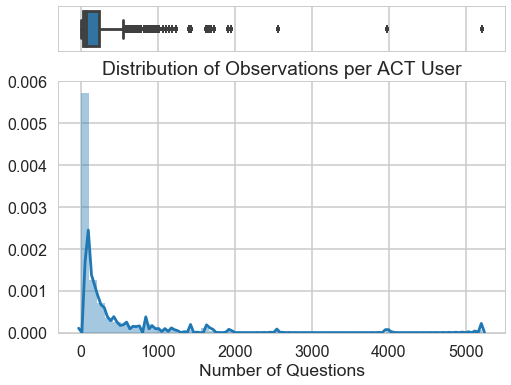

In [65]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(act.num_questions, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(act.num_questions, ax=histogram)

# Label axes and add title:
plt.xlabel('Number of Questions')
plt.title('Distribution of Observations per ACT User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [66]:
act_users['many'] = np.where(act_users.num_questions > 1250, 1, 0)

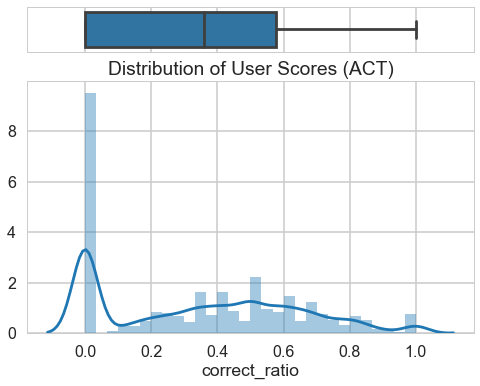

In [67]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(act_users.correct_ratio, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(act_users.correct_ratio, ax=histogram)

# Label axes and add title:
plt.title('Distribution of User Scores (ACT)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [68]:
# Number of users with score == 0
print(('Number of ACT users with no correct answers:'), len(act_users[act_users.correct_ratio == 0])) 

Number of ACT users with no correct answers: 12198


In [69]:
# ACT users with more than a few attempts and no correct answers:
act_users[(act_users.correct_ratio == act_users.correct_ratio.min()) & (act_users.few == False)]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
70,0,9,9,0,0,0.0,00:21:05,00:02:20.555555,0,0
99,0,6,6,0,0,0.0,00:01:45,00:00:17.500000,0,0
808,0,6,6,0,0,0.0,00:22:41,00:03:46.833333,0,0
1187,0,10,10,0,0,0.0,00:02:41,00:00:16.100000,0,0
1286,0,8,8,0,0,0.0,00:06:57,00:00:52.125000,0,0
1353,0,19,19,0,0,0.0,00:14:28,00:00:45.684210,0,0
1364,0,8,8,0,0,0.0,00:09:48,00:01:13.500000,0,0
1447,0,10,10,0,0,0.0,00:09:33,00:00:57.300000,0,0
1701,0,6,6,0,0,0.0,00:09:32,00:01:35.333333,0,0


In [70]:
# For users with no correct answers, view the number of users attempting each num_question value:
act_users[act_users.correct_ratio == 0].num_questions.value_counts()

1      7358
2      2334
3      1014
4       500
5       416
6       216
7       106
8        73
9        50
10       35
11       28
13       13
16        9
12        9
17        7
19        6
14        3
23        3
15        3
20        3
30        2
59        1
29        1
34        1
18        1
233       1
69        1
62        1
24        1
21        1
37        1
Name: num_questions, dtype: int64

One user attempted 233 questions and didn't answer any of them correctly. 

In [71]:
act_users[(act_users.correct_ratio == 0) & (act_users.num_questions == 233)]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
100283,0,233,233,0,0,0.0,00:36:04,00:00:09.287553,0,0


In [72]:
df[df.user_id.isin(act_users[(act_users.correct_ratio == 0) & (act_users.num_questions == 233)].index.values)]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts,outcome
3253509,100283,2011-07-01 03:34:51,NaT,2011-07-01 03:38:51,2011-07-01 03:38:51,0,3684,act,0,2,65 156 172,0,7,1,00:04:00,0,0,233,0,0,0,0,incorrect
3253510,100283,2011-07-01 03:40:09,2011-07-01 03:41:02,2011-07-01 03:41:23,2011-07-01 03:41:02,0,1064,act,0,2,65 247 274 280,0,7,1,00:00:53,0,0,233,0,0,0,0,incorrect
3253511,100283,2011-07-01 03:41:23,2011-07-01 03:41:55,2011-07-01 03:41:58,2011-07-01 03:41:55,0,4684,act,0,2,65 133,0,7,1,00:00:32,0,0,233,0,0,0,0,incorrect
3253512,100283,2011-07-01 03:41:58,2011-07-01 03:42:29,2011-07-01 03:42:32,2011-07-01 03:42:29,0,2620,act,0,2,65 107 133 247,0,7,1,00:00:31,0,0,233,0,0,0,0,incorrect
3253513,100283,2011-07-01 03:42:32,2011-07-01 03:43:03,2011-07-01 03:43:07,2011-07-01 03:43:03,0,4019,act,0,2,38 65 70 172,0,7,1,00:00:31,0,0,233,0,0,0,0,incorrect
3253514,100283,2011-07-01 03:43:07,2011-07-01 03:43:44,2011-07-01 03:43:47,2011-07-01 03:43:44,0,196,act,0,2,65 140 267 280,0,7,1,00:00:37,0,0,233,0,0,0,0,incorrect
3253515,100283,2011-07-01 03:43:47,2011-07-01 03:44:24,2011-07-01 03:44:26,2011-07-01 03:44:24,0,3327,act,0,2,38 65 70,0,7,1,00:00:37,0,0,233,0,0,0,0,incorrect
3253516,100283,2011-07-01 03:44:26,2011-07-01 03:45:00,2011-07-01 03:45:03,2011-07-01 03:45:00,0,744,act,0,2,65 173 280,0,7,1,00:00:34,0,0,233,0,0,0,0,incorrect
3253517,100283,2011-07-01 03:45:03,2011-07-01 03:45:26,2011-07-01 03:45:28,2011-07-01 03:45:26,0,4147,act,0,2,65 70 210 267,0,7,1,00:00:23,0,0,233,0,0,0,0,incorrect
3253518,100283,2011-07-01 03:45:28,2011-07-01 03:45:52,2011-07-01 03:45:55,2011-07-01 03:45:52,0,5033,act,0,2,57 63 65 140 173,0,7,1,00:00:24,0,0,233,0,0,0,0,incorrect


This user was borderline slow in attempting questions, but nothing stands out to help explain the poor performance. 

In [73]:
act_users_30.describe()

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
count,4815.000000,4815.000000,4815.000000,4815.0,4815.000000,4815.000000,4815,4815,4815.0,4815.000000
mean,53.737279,48.241121,101.978401,0.0,0.000208,0.507080,0 days 01:25:56.633437,0 days 00:00:50.990146,0.0,0.004154
std,103.003859,82.068733,175.290142,0.0,0.014411,0.166283,0 days 02:39:00.641478,0 days 00:00:24.816683,0.0,0.064322
min,0.000000,0.000000,30.000000,0.0,0.000000,0.000000,0 days 00:01:41,0 days 00:00:01.304347,0.0,0.000000
25%,18.000000,19.000000,39.000000,0.0,0.000000,0.385965,0 days 00:28:50,0 days 00:00:34.942653,0.0,0.000000
50%,28.000000,28.000000,55.000000,0.0,0.000000,0.511628,0 days 00:45:28,0 days 00:00:47.684210,0.0,0.000000
75%,51.000000,49.000000,98.000000,0.0,0.000000,0.628571,0 days 01:24:25,0 days 00:01:01.927055,0.0,0.000000
max,2911.000000,2298.000000,5209.000000,0.0,1.000000,1.000000,3 days 02:22:31,0 days 00:05:33.343750,0.0,1.000000


In [74]:
n = len(act_users_30.correct_ratio)
M = np.mean(act_users_30.correct_ratio)
s = np.std(act_users_30.correct_ratio)

# Simulate a random sample with the same statistics and size of 10,000:
np.random.seed(42)
normal = np.random.normal(M, s, 10000)

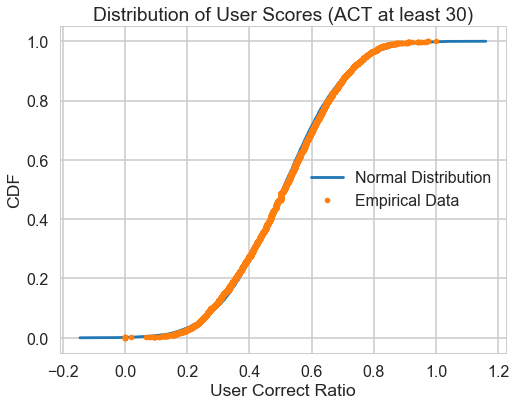

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))

# Compute CDFs:
x_score, y_score = cdf(act_users_30.correct_ratio)
x_norm, y_norm = cdf(normal)

# Plot both CDFs on the same plot:
fig = plt.plot(x_norm, y_norm)
fig = plt.plot(x_score, y_score, marker='.', linestyle='none')

# Label axes and add legend and a title:
fig = plt.xlabel('User Correct Ratio')
fig = plt.ylabel('CDF')
fig = plt.legend(('Normal Distribution', 'Empirical Data'), loc='center right')
fig = plt.title('Distribution of User Scores (ACT at least 30)');

In [76]:
# Number of users with score == 0
print(('Number of ACT users with no correct answers:'), len(act_users_30[act_users_30.correct_ratio == 0])) 

Number of ACT users with no correct answers: 8


In [77]:
act_users_30[act_users_30.correct_ratio == act_users_30.correct_ratio.min()]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
45031,0,30,30,0,0,0.0,01:07:46,00:02:15.533333,0,0
56124,0,37,37,0,0,0.0,00:32:44,00:00:53.081081,0,0
64390,0,30,30,0,0,0.0,00:38:51,00:01:17.700000,0,0
100283,0,233,233,0,0,0.0,00:36:04,00:00:09.287553,0,0
106065,0,62,62,0,0,0.0,00:05:22,00:00:05.193548,0,0
122241,0,59,59,0,0,0.0,00:44:49,00:00:45.576271,0,0
143737,0,69,69,0,0,0.0,00:06:47,00:00:05.898550,0,0
158712,0,34,34,0,0,0.0,00:42:18,00:01:14.647058,0,0


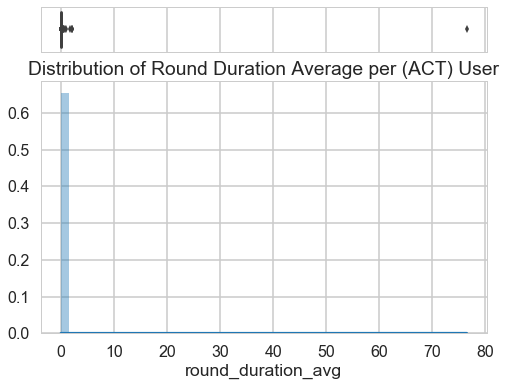

In [78]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(act_users.round_duration_avg/np.timedelta64(1, 'h'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(act_users.round_duration_avg/np.timedelta64(1, 'h'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (ACT) User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

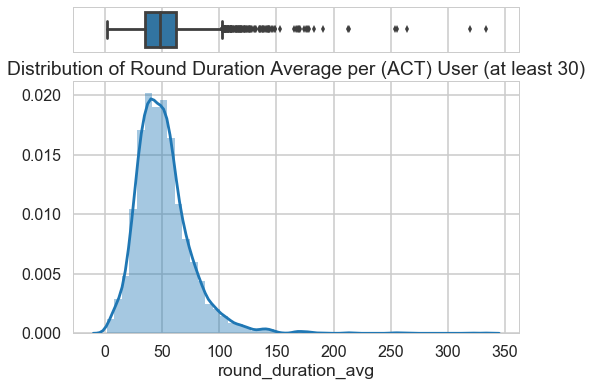

In [79]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(act_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(act_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (ACT) User (at least 30)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

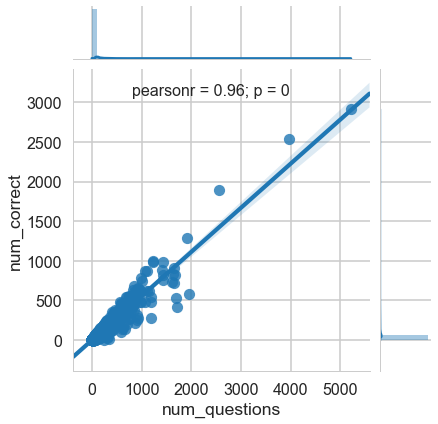

In [80]:
sns.jointplot(act_users.num_questions, act_users.num_correct, kind='reg', size=6);

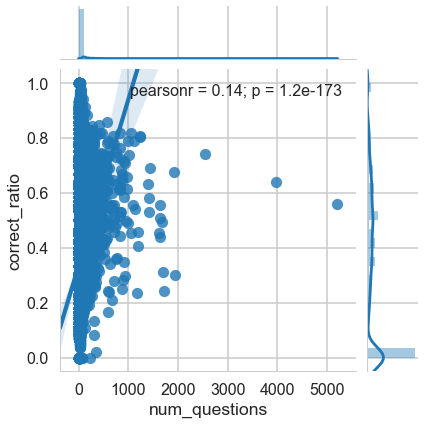

In [81]:
sns.jointplot(act_users.num_questions, act_users.correct_ratio, kind='reg', size=6)
plt.ylim(-0.05, 1.05);

The number of correct answers has an expected strong positive relationship with the number of questions attempted. However, the ratio of correct answers most definitely does not. There are obvious outliers above the 2000 question mark with scores below 80% correct.

In [82]:
act_users[act_users['num_questions'] > 2000]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
38941,1889,663,2552,0,1,0.740204,1 days 06:55:39,00:00:43.628134,0,0
47833,2541,1435,3976,0,1,0.639085,0 days 18:16:21,00:00:16.544517,0,0
132295,2911,2298,5209,0,1,0.558840,3 days 02:22:31,00:00:51.401612,0,0


The user with the most questions had the lowest score. A look at that user's statistics follows:

In [83]:
act[act.user_id == 132295][categorical].describe()

,user_id,question_id,group_name,track_name,subtrack_name,question_type,game_type,num_players,fast,slow,prior_attempts,excessive_attempts,outcome,few,many,slow_avg,fast_avg
count,5209,5209,5209,5209,5209,5209,5209,5209,5209,5209,5209,5209,5209,5209,5209,5209,5209
unique,1,1981,1,4,4,1,6,7,2,2,10,1,2,1,1,1,1
top,132295,4315,act,0,2,0,7,1,0,0,0,0,correct,0,1,0,0
freq,5209,10,5209,3111,3111,5209,4701,3402,5095,5208,1981,5209,2911,5209,5209,5209,5209


In [84]:
act[(act.user_id == 132295) & (act.num_players == 1)].describe()

,correct,round_duration,num_correct,num_incorrect,num_questions,correct_ratio,total_practice,round_duration_avg
count,3402.000000,3402,3402.0,3402.0,3402.0,3.402000e+03,3402,3402
mean,0.557907,0 days 00:00:38.325984,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612
std,0.496708,0 days 00:00:38.172573,0.0,0.0,0.0,5.063361e-14,0 days 00:00:00,0 days 00:00:00
min,0.000000,0 days 00:00:01,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612
25%,0.000000,0 days 00:00:13,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612
50%,1.000000,0 days 00:00:25,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612
75%,1.000000,0 days 00:00:50,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612
max,1.000000,0 days 00:10:35,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612


In [85]:
act[(act.user_id == 132295) & (act.num_players > 1)].describe()

,correct,round_duration,num_correct,num_incorrect,num_questions,correct_ratio,total_practice,round_duration_avg
count,1807.000000,1807,1807.0,1807.0,1807.0,1.807000e+03,1807,1807
mean,0.560598,0 days 00:01:16.018815,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612
std,0.496452,0 days 00:01:00.242906,0.0,0.0,0.0,1.776849e-15,0 days 00:00:00,0 days 00:00:00
min,0.000000,0 days 00:00:01,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612
25%,0.000000,0 days 00:00:28,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612
50%,1.000000,0 days 00:00:57,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612
75%,1.000000,0 days 00:01:54,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612
max,1.000000,0 days 00:05:42,2911.0,2298.0,5209.0,5.588405e-01,3 days 02:22:31,0 days 00:00:51.401612


Practicing with other users, this user performed slightly better albeit slower than practicing alone. Nothing indicates this user or the other outliers above should be eliminated.

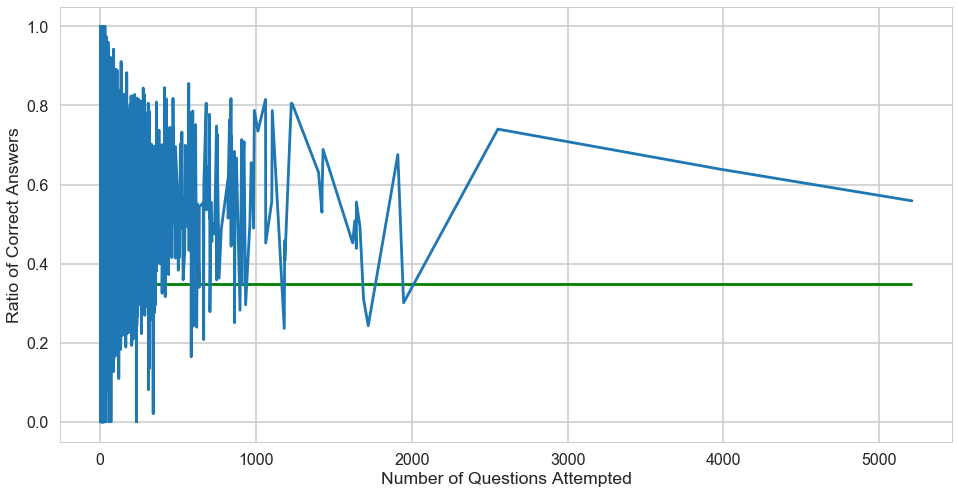

In [86]:
scores_by_num_questions = act_users.sort_values('num_questions')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_num_questions.num_questions, scores_by_num_questions.correct_ratio)
plt.hlines(xmin=0, xmax=scores_by_num_questions.num_questions.max(), y=scores_by_num_questions.correct_ratio.mean(), color='green')
plt.xlabel('Number of Questions Attempted')
plt.ylabel('Ratio of Correct Answers');

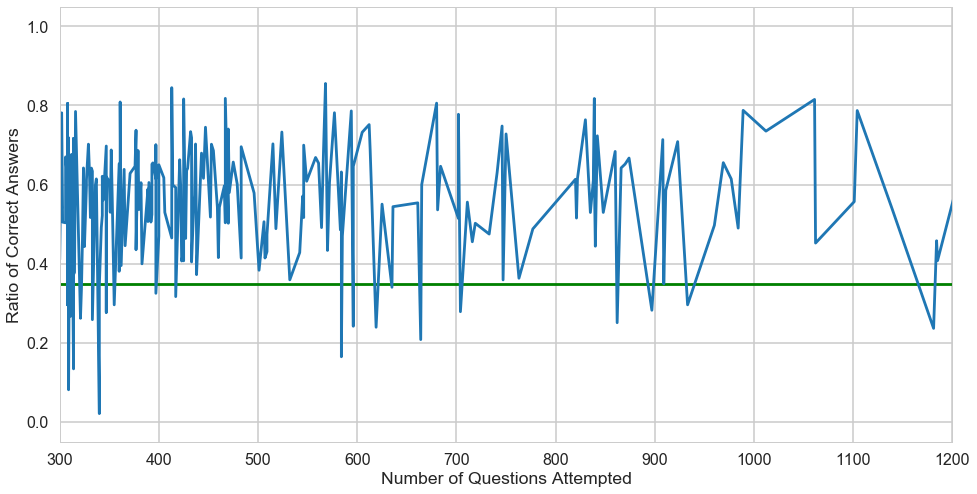

In [87]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_num_questions.num_questions, scores_by_num_questions.correct_ratio)
plt.hlines(xmin=0, xmax=scores_by_num_questions.num_questions.max(), y=scores_by_num_questions.correct_ratio.mean(), color='green')
plt.xlabel('Number of Questions Attempted')
plt.ylabel('Ratio of Correct Answers')
plt.xlim(300, 1200);

Users attempting about 350 to about 575 questions consistently perform above the average ratio of correct answers.

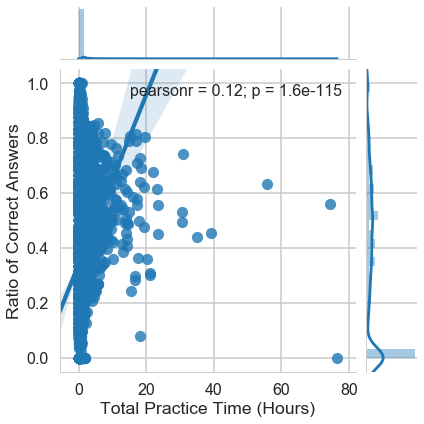

In [88]:
sns.jointplot(act_users['total_practice']/np.timedelta64(1, 'h'), act_users.correct_ratio, kind='reg', size=6)
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers')
plt.ylim(-0.05, 1.05);

So far this looks a lot like the `num_questions` comparisons, but there is one user who spent a lot of time on the test application with no correct answers.

In [89]:
act_users[act_users['total_practice']/np.timedelta64(1, 'h') > 40]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
57389,884,517,1401,0,1,0.630978,2 days 07:49:45,0 days 00:02:23.458244,0,0
75348,0,1,1,1,0,0.000000,3 days 04:29:45,3 days 04:29:45,1,0
132295,2911,2298,5209,0,1,0.558840,3 days 02:22:31,0 days 00:00:51.401612,0,0


In [90]:
# Inspect this user's data, but also make sure the user participated only in this group:
df[df.user_id == 75348]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts,outcome
788661,75348,2010-01-07 18:37:22,NaT,2010-01-10 23:07:07,2010-01-10 23:07:07,0,4004,act,3,12,34 90 102 114 146 212 243,0,7,5,3 days 04:29:45,0,1,1,1,0,0,0,incorrect


In [91]:
act[act.question_id == 4004].describe()

,correct,round_duration,num_correct,num_incorrect,num_questions,correct_ratio,total_practice,round_duration_avg
count,238.000000,238,238.000000,238.000000,238.000000,238.000000,238,238
mean,0.218487,0 days 00:19:58.584033,227.722689,175.642857,403.365546,0.489929,0 days 05:57:28.495798,0 days 00:20:03.232930
std,0.414091,0 days 04:57:27.911950,405.031768,303.572433,675.311652,0.189344,0 days 10:57:28.768407,0 days 04:57:27.567200
min,0.000000,0 days 00:00:01,0.000000,1.000000,1.000000,0.000000,0 days 00:00:21,0 days 00:00:04.477561
25%,0.000000,0 days 00:00:12,17.250000,22.500000,43.250000,0.363636,0 days 00:24:23,0 days 00:00:32.647899
50%,0.000000,0 days 00:00:30,71.000000,78.000000,164.500000,0.501043,0 days 01:46:20.500000,0 days 00:00:44.756933
75%,0.000000,0 days 00:00:56,242.000000,174.000000,420.000000,0.625548,0 days 05:59:11.250000,0 days 00:00:58.381395
max,1.000000,3 days 04:29:45,2911.000000,2298.000000,5209.000000,0.837838,3 days 04:29:45,3 days 04:29:45


In [92]:
act[act.question_id == 4004][categorical].describe()

,user_id,question_id,group_name,track_name,subtrack_name,question_type,game_type,num_players,fast,slow,prior_attempts,excessive_attempts,outcome,few,many,slow_avg,fast_avg
count,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238
unique,211,1,1,1,1,1,4,5,2,2,3,1,2,2,2,2,2
top,147414,4004,act,3,12,0,7,1,0,0,0,0,incorrect,0,0,0,0
freq,3,238,238,238,238,238,203,189,206,237,211,238,186,229,236,237,237


The question the user attempted may be problematic. Users answered it correctly for little more than 20% of the attempts and the average round_duration for the question is almost 20 minutes. One of 238 attempts shouldn't change the score much, but a round of 3 days would certainly skew the average. It seems this user gave up and never logged out.

In [93]:
# Redefine the dataframe without the user scrutinized above:
act = df2[df2['group_name'] == 'act']
act = act[act.user_id != 75348]
act, act_users = user_stats(act)

In [94]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    act[column] = act[column].astype('category')

# Convert ordered categorical variables:
act['num_players'] = pd.Categorical(act['num_players'], ordered=True)
act['prior_attempts'] = pd.Categorical(act['prior_attempts'], ordered=True)

In [95]:
act[act.question_id == 4004][['correct', 'round_duration']].describe()

,correct,round_duration
count,237.000000,237
mean,0.219409,0 days 00:00:41.679324
std,0.414722,0 days 00:00:44.555223
min,0.000000,0 days 00:00:01
25%,0.000000,0 days 00:00:12
50%,0.000000,0 days 00:00:30
75%,0.000000,0 days 00:00:56
max,1.000000,0 days 00:04:00


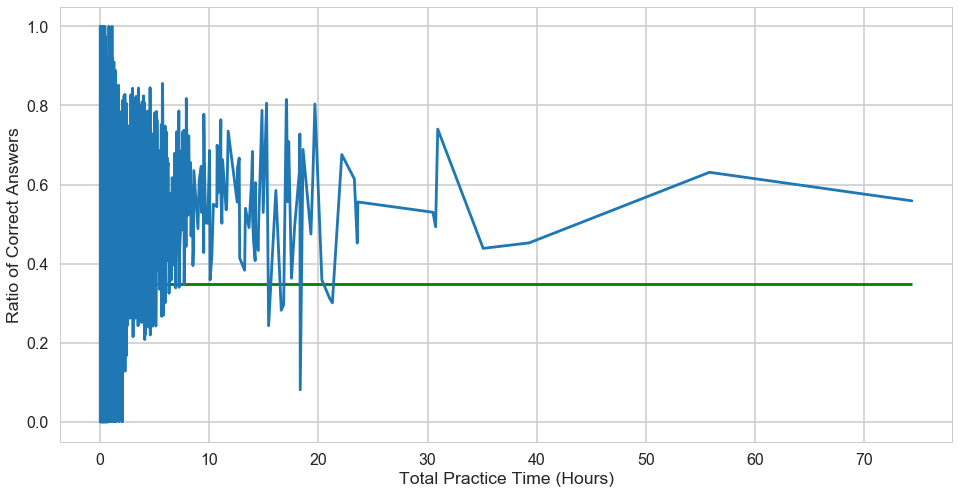

In [96]:
scores_by_total_practice = act_users.sort_values('total_practice')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_total_practice.total_practice/np.timedelta64(1, 'h'), scores_by_total_practice.correct_ratio)
plt.hlines(xmin=0, xmax=(scores_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=scores_by_total_practice.correct_ratio.mean(), color='green')
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers');

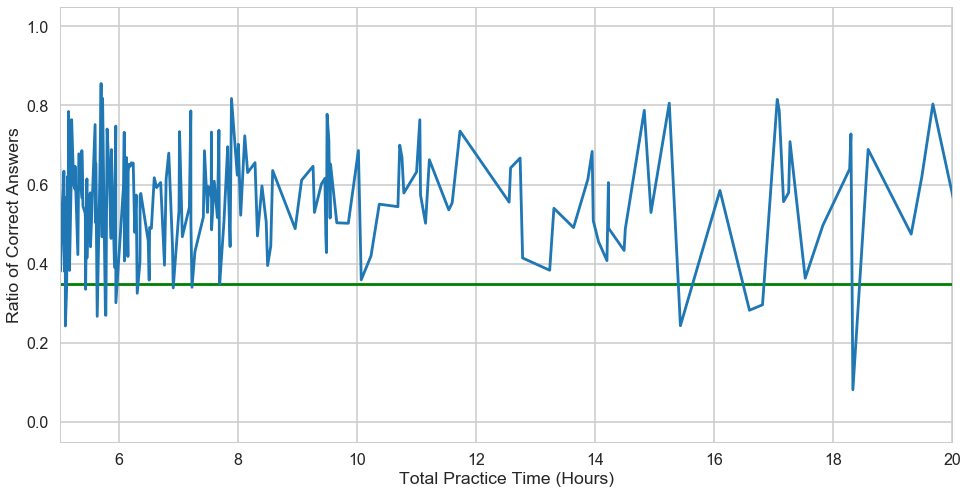

In [97]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_total_practice.total_practice/np.timedelta64(1, 'h'), scores_by_total_practice.correct_ratio)
plt.hlines(xmin=0, xmax=(scores_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=scores_by_total_practice.correct_ratio.mean(), color='green')
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers')
plt.xlim(5, 20);

Users practicing for 6 to about 15 hours consistently perform above the average ratio of correct answers.

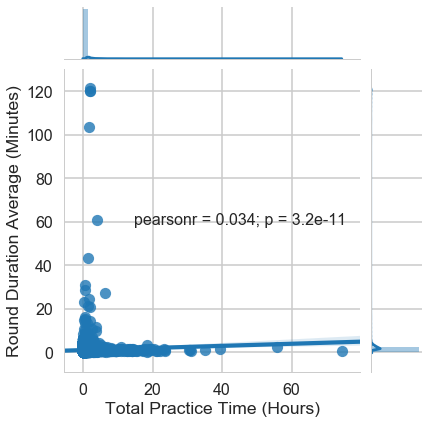

In [98]:
sns.jointplot(act_users['total_practice']/np.timedelta64(1, 'h'), act_users.round_duration_avg/np.timedelta64(1, 'm'), kind='reg', size=6)
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Minutes)');

In [99]:
act_users[act_users['round_duration_avg']/np.timedelta64(1, 'm') > 40]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
44639,0,1,1,1,0,0.0,02:00:16,02:00:16,1,0
53471,0,1,1,1,0,0.0,02:00:08,02:00:08,1,0
61625,2,2,4,1,0,0.5,04:02:41,01:00:40.250000,1,0
108137,0,2,2,1,0,0.0,01:27:14,00:43:37,1,0
120180,0,1,1,1,0,0.0,01:43:32,01:43:32,1,0
171707,0,1,1,1,0,0.0,02:01:23,02:01:23,1,0


The user dropped earlier was revealed to be an outlier based on `round_duration_avg`. That value was so extreme, the other abnormally high averages were missed.

In [100]:
act[act.user_id.isin(act_users[act_users['round_duration_avg']/np.timedelta64(1, 'm') > 40].index.values)]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
47350,108137,2011-10-31 16:49:05,2011-10-31 18:15:00,2011-10-31 18:15:03,2011-10-31 18:15:00,0,3836,act,0,2,63 65 70 173,0,7,1,01:25:55,0,1,0,0,incorrect,0,2,2,1,0,0.0,01:27:14,00:43:37,1,0
47351,108137,2011-10-31 18:15:12,NaT,2011-10-31 18:16:31,2011-10-31 18:16:31,0,4658,act,0,2,65 133 274,0,7,1,00:01:19,0,0,0,0,incorrect,0,2,2,1,0,0.0,01:27:14,00:43:37,1,0
99417,61625,2011-09-19 19:19:52,NaT,2011-09-19 21:20:08,2011-09-19 21:20:08,0,5937,act,2,10,17 122 171 206,0,7,1,02:00:16,0,1,0,0,incorrect,2,2,4,1,0,0.5,04:02:41,01:00:40.250000,1,0
99418,61625,2011-09-19 22:09:30,2011-09-19 22:11:52,2011-09-19 22:11:54,2011-09-19 22:11:52,1,3836,act,0,2,63 65 70 173,0,7,1,00:02:22,0,0,0,0,correct,2,2,4,1,0,0.5,04:02:41,01:00:40.250000,1,0
99419,61625,2011-09-19 22:12:10,2011-09-19 22:12:13,2011-09-19 22:12:14,2011-09-19 22:12:13,1,4658,act,0,2,65 133 274,0,7,1,00:00:03,1,0,0,0,correct,2,2,4,1,0,0.5,04:02:41,01:00:40.250000,1,0
99420,61625,2011-09-19 22:12:16,NaT,2011-09-20 00:12:16,2011-09-20 00:12:16,0,28,act,0,2,65 133 247 274,0,7,1,02:00:00,0,1,0,0,incorrect,2,2,4,1,0,0.5,04:02:41,01:00:40.250000,1,0
226341,53471,2011-10-01 02:34:22,NaT,2011-10-01 04:34:30,2011-10-01 04:34:30,0,3836,act,0,2,63 65 70 173,0,7,1,02:00:08,0,1,0,0,incorrect,0,1,1,1,0,0.0,02:00:08,02:00:08,1,0
316161,44639,2011-05-22 23:51:35,NaT,2011-05-23 01:51:51,2011-05-23 01:51:51,0,2632,act,3,12,34 51 61 212 243,0,7,1,02:00:16,0,1,0,0,incorrect,0,1,1,1,0,0.0,02:00:16,02:00:16,1,0
354486,120180,2011-06-30 16:52:55,NaT,2011-06-30 18:36:27,2011-06-30 18:36:27,0,1064,act,0,2,65 247 274 280,0,7,1,01:43:32,0,1,0,0,incorrect,0,1,1,1,0,0.0,01:43:32,01:43:32,1,0
583005,171707,2011-10-19 00:16:01,NaT,2011-10-19 02:17:24,2011-10-19 02:17:24,0,4559,act,1,6,8 82 125 148 167 204 279,0,11,1,02:01:23,0,1,0,0,incorrect,0,1,1,1,0,0.0,02:01:23,02:01:23,1,0


This seems to point to a couple of problematic questions within one problematic subtrack. These users are kept since the questions they attempted could be a predictor of outcome.

---
Outliers aside, one might expect users to become more efficient and consistent with more practice. The extreme values are somewhat understood, so a narrower view of `round_duration_avg` across total practice time follows.

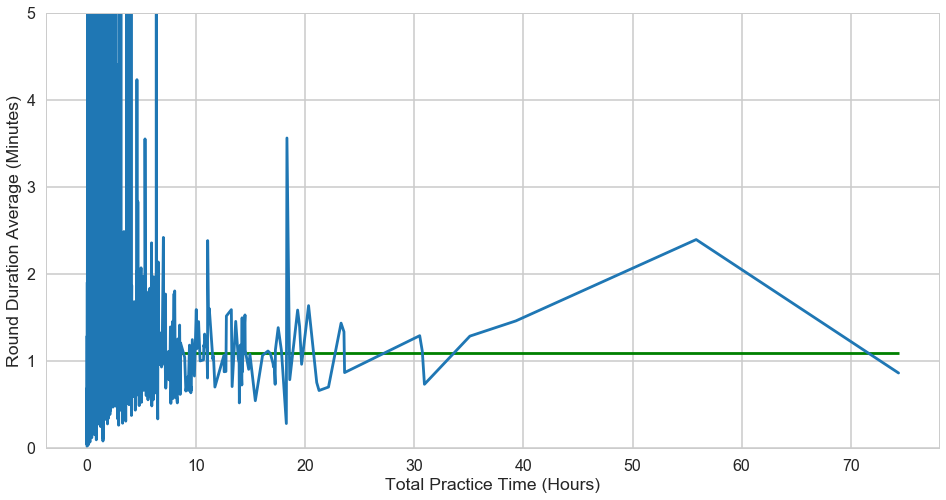

In [101]:
round_by_total_practice = act_users.sort_values('total_practice')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(round_by_total_practice.total_practice/np.timedelta64(1, 'h'), round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm'))
plt.hlines(xmin=0, xmax=(round_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=(round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm')).mean(), color='green')
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Minutes)')
plt.ylim(0, 5);

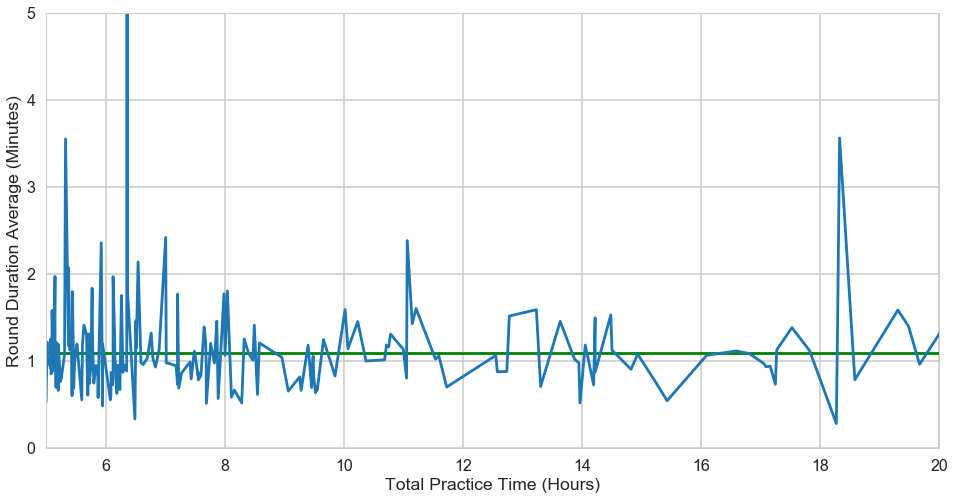

In [102]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(round_by_total_practice.total_practice/np.timedelta64(1, 'h'), round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm'))
plt.hlines(xmin=0, xmax=(round_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=(round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm')).mean(), color='green')
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Minutes)')
plt.xlim(5, 20), plt.ylim(0, 5);

Users practicing between 7 and 18 hours more consistently approached the average amount of time attempting a question.

## Question Data (ACT)

In [103]:
# Question statistics for users attempting a few rounds at a slow pace:
act[act.user_id.isin(act_users[(act_users.slow_avg == True) & (act_users.few == True)].index.values)][categorical].describe()

,user_id,question_id,group_name,track_name,subtrack_name,question_type,game_type,num_players,fast,slow,prior_attempts,excessive_attempts,outcome,few,many,slow_avg,fast_avg
count,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39
unique,18,30,1,4,4,1,3,1,2,2,2,1,2,1,1,1,1
top,49102,5937,act,0,2,0,7,1,0,0,0,0,incorrect,1,0,1,0
freq,5,5,39,12,12,39,33,39,38,20,38,39,29,39,39,39,39


Other than slow and few, nothing stands out much. At least one question is represented more than once in this group. The following may be some of the most difficult questions.

In [104]:
act[act.user_id.isin(act_users[(act_users.slow_avg == True) & (act_users.few == True)].index.values)].question_id.value_counts().head(5)

5937    5
3836    4
4658    2
5528    2
2791    1
Name: question_id, dtype: int64

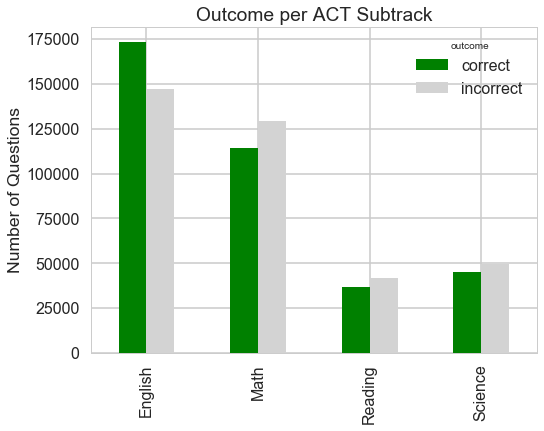

In [105]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=act.subtrack_name, columns=[act.outcome]).plot(kind='bar', color=('green', 'lightgrey'), figsize=(8, 6))

# Create bar labels:
subtracks = ('English', 'Math', 'Reading', 'Science')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per ACT Subtrack');

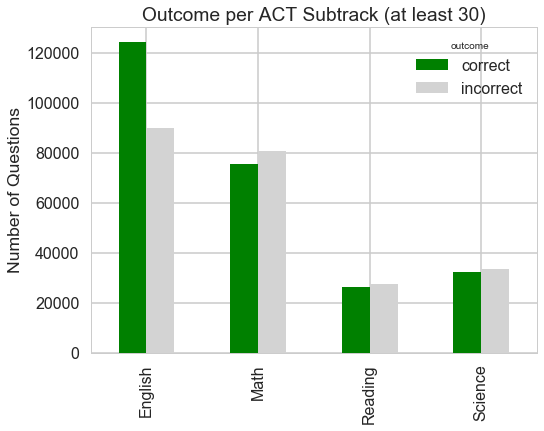

In [106]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=act_30.subtrack_name, columns=[act_30.outcome]).plot(kind='bar', color=('green', 'lightgrey'), figsize=(8, 6))

# Create bar labels:
subtracks = ('English', 'Math', 'Reading', 'Science')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per ACT Subtrack (at least 30)');

Outcomes are better across all subjects for users attempting at least questions.

In [177]:
# Save the clean dataframe to the interim data directory:
act.to_csv('../data/interim/clean_act.csv')

---
## GMAT EDA

In [107]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    gmat[column] = gmat[column].astype('category')

# Convert ordered categorical variables:
gmat['num_players'] = pd.Categorical(gmat['num_players'], ordered=True)
gmat['prior_attempts'] = pd.Categorical(gmat['prior_attempts'], ordered=True)

In [108]:
print('Group name statistics associated with excessive prior attempts:')
gmat[gmat.excessive_attempts == True].group_name.describe()

Group name statistics associated with excessive prior attempts:


count     0
unique    0
Name: group_name, dtype: int64

## All Observations (GMAT)

In [109]:
# Display statistics for numerical variables:
gmat.describe()

,correct,round_duration,num_correct,num_incorrect,num_questions,correct_ratio,total_practice,round_duration_avg
count,2.371388e+06,2371388,2.371388e+06,2.371388e+06,2.371388e+06,2.371388e+06,2371388,2371388
mean,5.606400e-01,0 days 00:01:18.064992,5.459370e+02,3.349056e+02,8.808426e+02,5.606400e-01,0 days 18:52:32.530209,0 days 00:01:18.064992
std,4.963093e-01,0 days 00:01:57.622049,7.341407e+02,4.219883e+02,1.113559e+03,1.727462e-01,0 days 23:14:14.481460,0 days 00:01:00.715739
min,0.000000e+00,0 days 00:00:01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0 days 00:00:01,0 days 00:00:01
25%,0.000000e+00,0 days 00:00:37,2.900000e+01,2.500000e+01,5.700000e+01,4.796748e-01,0 days 01:09:19,0 days 00:01:05.200819
50%,1.000000e+00,0 days 00:01:06,2.660000e+02,1.900000e+02,4.780000e+02,5.833333e-01,0 days 10:10:14,0 days 00:01:16.869565
75%,1.000000e+00,0 days 00:01:47,7.610000e+02,4.750000e+02,1.264000e+03,6.699387e-01,1 days 04:08:32,0 days 00:01:28.363636
max,1.000000e+00,0 days 19:44:07,4.589000e+03,2.677000e+03,6.666000e+03,1.000000e+00,5 days 05:37:33,0 days 19:44:07


In [110]:
# Filter columns for category datatype and display the statistics:
categorical = gmat.dtypes[gmat.dtypes == 'category'].index
gmat[categorical].describe()

,user_id,question_id,group_name,track_name,subtrack_name,question_type,game_type,num_players,fast,slow,prior_attempts,excessive_attempts,outcome,few,many,slow_avg,fast_avg
count,2371388,2371388,2371388,2371388,2371388,2371388,2371388,2371388,2371388,2371388,2371388,2371388,2371388,2371388,2371388,2371388,2371388
unique,78488,2203,1,2,5,1,11,22,2,2,47,1,2,2,2,2,2
top,94877,4059,gmat,5,9,0,7,1,0,0,0,0,correct,0,0,0,0
freq,6666,14416,2371388,1231831,717200,2371388,1163856,1622512,2322034,2368415,2067223,2371388,1329495,2269458,2315725,2371237,2367986


## At least 30 Questions per User (GMAT)

In [111]:
# Save and inspect a dataframe of observations for the ACT group only:
gmat2 = df2[df2['group_name'] == 'gmat']
gmat_30 = gmat2.groupby('user_id').filter(lambda x: x['user_id'].count() >= 30)
gmat_30, gmat_users_30 = user_stats(gmat_30)
gmat_30.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,0,5560,gmat,5,14,222 233 240 246,0,7,1,00:01:05,0,0,0,0,incorrect,169,146,315,0,0,0.536508,07:42:42,00:01:28.133333,0,0
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,1,4681,gmat,5,0,24 49,0,7,1,00:01:22,0,0,0,0,correct,169,146,315,0,0,0.536508,07:42:42,00:01:28.133333,0,0
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,1,1529,gmat,5,0,31 49,0,7,1,00:01:14,0,0,0,0,correct,169,146,315,0,0,0.536508,07:42:42,00:01:28.133333,0,0
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,1,2908,gmat,5,0,31 49,0,7,1,00:01:02,0,0,0,0,correct,169,146,315,0,0,0.536508,07:42:42,00:01:28.133333,0,0
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,1,1773,gmat,5,11,183 194 207,0,7,1,00:02:57,0,0,0,0,correct,169,146,315,0,0,0.536508,07:42:42,00:01:28.133333,0,0


In [112]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    gmat_30[column] = gmat_30[column].astype('category')

# Convert ordered categorical variables:
gmat_30['num_players'] = pd.Categorical(gmat_30['num_players'], ordered=True)
gmat_30['prior_attempts'] = pd.Categorical(gmat_30['prior_attempts'], ordered=True)

## User Data (GMAT)

In [113]:
gmat_users.head()

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
1,6,8,14,0,0,0.428571,00:21:45,00:01:33.214285,0,0
3,3,4,7,0,0,0.428571,00:07:52,00:01:07.428571,0,0
4,7,4,11,0,0,0.636364,00:07:09,00:00:39,0,0
8,2,8,10,0,0,0.200000,00:15:31,00:01:33.100000,0,0
12,10,13,23,0,0,0.434783,00:17:21,00:00:45.260869,0,0


In [114]:
# Confirm the count of users:
print( ("Number of GMAT Users: "), len(gmat.user_id.value_counts()) )

Number of GMAT Users:  78488


In [115]:
gmat_users.describe()

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
count,78488.000000,78488.000000,78488.000000,78488.000000,78488.000000,78488.000000,78488,78488,78488.000000,78488.000000
mean,16.938831,13.274552,30.213383,0.515174,0.000140,0.333503,0 days 00:39:18.607519,0 days 00:01:14.181638,0.000624,0.006536
std,101.342963,63.285497,160.314423,0.499773,0.011838,0.306616,0 days 03:33:31.994217,0 days 00:04:54.353373,0.024978,0.080582
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0 days 00:00:01,0 days 00:00:01,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0 days 00:02:02,0 days 00:00:47.500000,0.000000,0.000000
50%,2.000000,3.000000,5.000000,1.000000,0.000000,0.333333,0 days 00:05:45,0 days 00:01:09.400000,0.000000,0.000000
75%,6.000000,6.000000,11.000000,1.000000,0.000000,0.571429,0 days 00:14:07,0 days 00:01:29.600000,0.000000,0.000000
max,4589.000000,2677.000000,6666.000000,1.000000,1.000000,1.000000,5 days 05:37:33,0 days 19:44:07,1.000000,1.000000


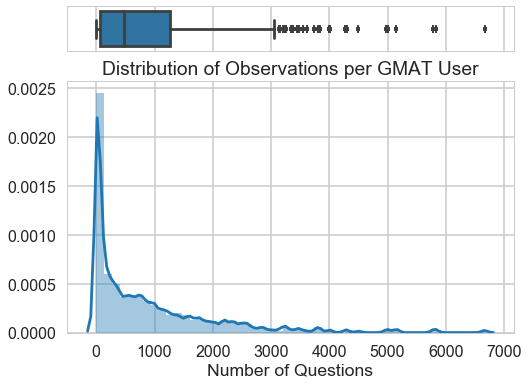

In [116]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(gmat.num_questions, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(gmat.num_questions, ax=histogram)

# Label axes and add title:
plt.xlabel('Number of Questions')
plt.title('Distribution of Observations per GMAT User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

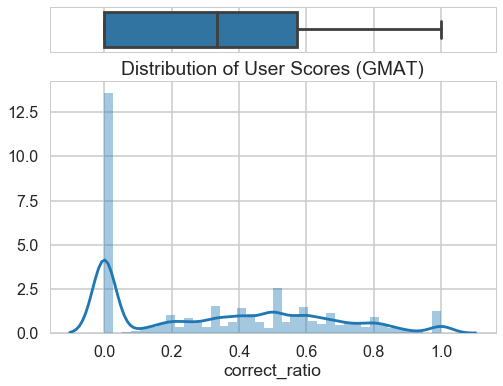

In [117]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(gmat_users.correct_ratio, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(gmat_users.correct_ratio, ax=histogram)

# Label axes and add title:
plt.title('Distribution of User Scores (GMAT)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [118]:
# Number of users with score == 0
print(('Number of GMAT users with no correct answers:'), len(gmat_users[gmat_users.correct_ratio == 0])) 

Number of GMAT users with no correct answers: 28007


In [119]:
gmat_users[(gmat_users.correct_ratio == gmat_users.correct_ratio.min()) & (gmat_users.few == False)]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
61,0,8,8,0,0,0.0,00:02:20,00:00:17.500000,0,0
69,0,6,6,0,0,0.0,00:12:37,00:02:06.166666,0,0
73,0,9,9,0,0,0.0,00:09:51,00:01:05.666666,0,0
156,0,12,12,0,0,0.0,00:27:21,00:02:16.750000,0,0
301,0,7,7,0,0,0.0,00:11:52,00:01:41.714285,0,0
497,0,7,7,0,0,0.0,00:08:03,00:01:09,0,0
747,0,6,6,0,0,0.0,00:05:39,00:00:56.500000,0,0
839,0,6,6,0,0,0.0,00:11:05,00:01:50.833333,0,0
927,0,6,6,0,0,0.0,00:03:52,00:00:38.666666,0,0


In [120]:
# For users with no correct answers, view the number of users attempting each num_question value:
gmat_users[gmat_users.correct_ratio == 0].num_questions.value_counts()

1     16043
2      5746
3      2381
5      1398
4      1243
6       430
7       279
8       182
9       100
10       68
11       39
12       26
13       16
14       11
15       10
16        9
19        6
20        5
17        4
22        3
21        2
37        1
23        1
18        1
26        1
29        1
32        1
Name: num_questions, dtype: int64

In [121]:
gmat_users_30.describe()

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
count,8436.000000,8436.000000,8436.000000,8436.0,8436.000000,8436.000000,8436,8436,8436.000000,8436.000000
mean,133.973092,93.729374,227.702466,0.0,0.001304,0.547034,0 days 05:01:31.253437,0 days 00:01:18.519090,0.000119,0.002371
std,283.009149,172.960337,441.730582,0.0,0.036089,0.157309,0 days 09:48:30.773527,0 days 00:00:50.251521,0.010888,0.048636
min,0.000000,0.000000,30.000000,0.0,0.000000,0.000000,0 days 00:01:00,0 days 00:00:01.301369,0.000000,0.000000
25%,21.000000,19.000000,40.000000,0.0,0.000000,0.446744,0 days 00:49:39.750000,0 days 00:01:04.207589,0.000000,0.000000
50%,37.000000,32.000000,68.000000,0.0,0.000000,0.552674,0 days 01:27:52,0 days 00:01:16.901373,0.000000,0.000000
75%,108.250000,84.000000,194.000000,0.0,0.000000,0.655577,0 days 04:21:52,0 days 00:01:29.431277,0.000000,0.000000
max,4589.000000,2677.000000,6666.000000,0.0,1.000000,1.000000,5 days 05:37:33,0 days 01:06:45.866666,1.000000,1.000000


In [122]:
n = len(gmat_users_30.correct_ratio)
M = np.mean(gmat_users_30.correct_ratio)
s = np.std(gmat_users_30.correct_ratio)

# Simulate a random sample with the same statistics and size of 10,000:
np.random.seed(42)
normal = np.random.normal(M, s, 10000)

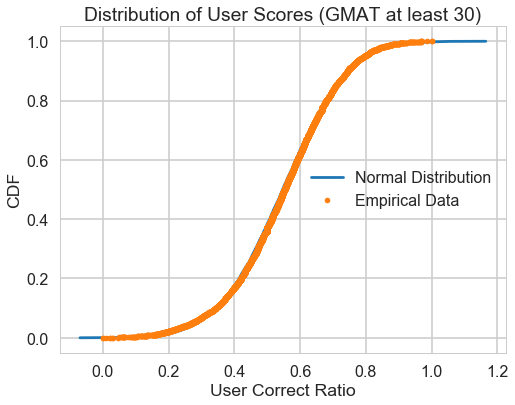

In [123]:
fig, ax = plt.subplots(figsize=(8, 6))

# Compute CDFs:
x_score, y_score = cdf(gmat_users_30.correct_ratio)
x_norm, y_norm = cdf(normal)

# Plot both CDFs on the same plot:
fig = plt.plot(x_norm, y_norm)
fig = plt.plot(x_score, y_score, marker='.', linestyle='none')

# Label axes and add legend and a title:
fig = plt.xlabel('User Correct Ratio')
fig = plt.ylabel('CDF')
fig = plt.legend(('Normal Distribution', 'Empirical Data'), loc='center right')
fig = plt.title('Distribution of User Scores (GMAT at least 30)');

In [124]:
# Number of users with score == 0
print(('Number of GMAT users with no correct answers:'), len(gmat_users_30[gmat_users_30.correct_ratio == 0])) 

Number of GMAT users with no correct answers: 2


In [125]:
gmat_users_30[gmat_users_30.correct_ratio == gmat_users_30.correct_ratio.min()]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
28859,0,32,32,0,0,0.0,01:14:35,00:02:19.843750,0,0
154426,0,37,37,0,0,0.0,00:58:54,00:01:35.513513,0,0


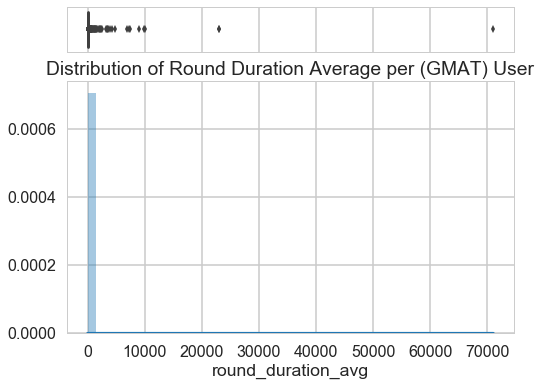

In [126]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(gmat_users.round_duration_avg/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(gmat_users.round_duration_avg/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (GMAT) User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

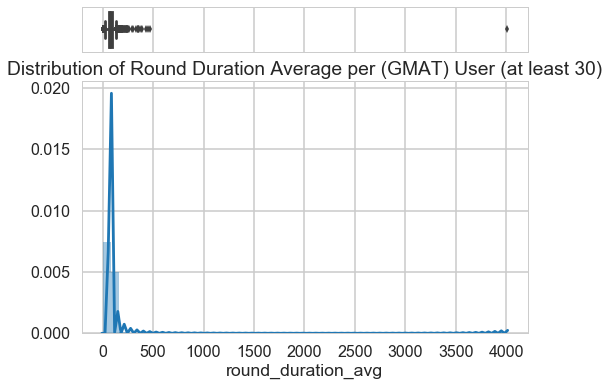

In [127]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(gmat_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(gmat_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (GMAT) User (at least 30)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

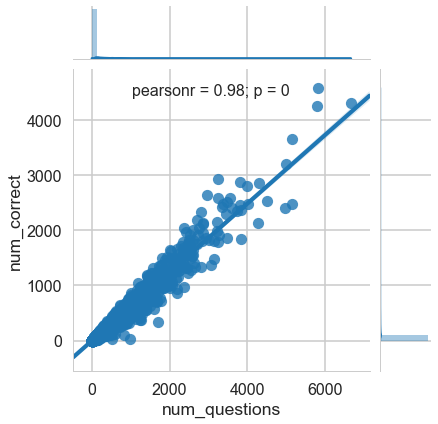

In [128]:
sns.jointplot(gmat_users.num_questions, gmat_users.num_correct, kind='reg', size=6);

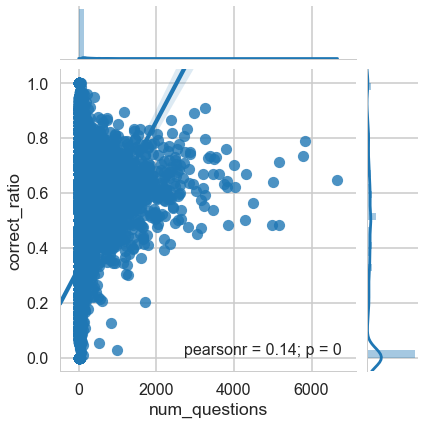

In [129]:
sns.jointplot(gmat_users.num_questions, gmat_users.correct_ratio, kind='reg', size=6)
plt.ylim(-0.05, 1.05);

In [130]:
gmat_users[gmat_users['num_questions'] > 4000]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
1914,3658,1490,5148,0,1,0.710567,4 days 01:25:42,00:01:08.131701,0,0
29274,2866,1433,4299,0,1,0.666667,2 days 02:27:57,00:00:42.260293,0,0
68653,3207,1804,5011,0,1,0.639992,3 days 21:56:47,00:01:07.492915,0,0
88590,2143,2134,4277,0,1,0.501052,3 days 18:38:49,00:01:16.298573,0,0
94877,4308,2358,6666,0,1,0.646265,3 days 19:48:11,00:00:49.578607,0,0
96046,4252,1534,5786,0,1,0.734877,3 days 23:38:16,00:00:59.505012,0,0
103056,2476,2677,5153,0,1,0.480497,3 days 16:47:05,00:01:02.026974,0,0
103201,2485,1530,4015,0,1,0.618929,4 days 15:56:51,00:01:40.376338,0,0
115950,2402,2571,4973,0,1,0.483008,4 days 19:08:53,00:01:23.356726,0,0


Other than not performing as well as a handful of users attempting 2000-4000 questions, nothing jumps out about the users attempting more than 4000 questions. Maybe a look at the least successful of these users will provide some insight.

In [132]:
gmat[gmat['user_id'] == 115950][categorical].describe()

,user_id,question_id,group_name,track_name,subtrack_name,question_type,game_type,num_players,fast,slow,prior_attempts,excessive_attempts,outcome,few,many,slow_avg,fast_avg
count,4973,4973,4973,4973,4973,4973,4973,4973,4973,4973,4973,4973,4973,4973,4973,4973,4973
unique,1,1790,1,2,5,1,7,11,2,1,12,1,2,1,1,1,1
top,115950,2873,gmat,5,14,0,4,1,0,0,0,0,incorrect,0,1,0,0
freq,4973,12,4973,4075,2256,4973,3473,2267,4912,4973,1790,4973,2571,4973,4973,4973,4973


In [133]:
gmat[(gmat['user_id'] == 115950) & (gmat.num_players == 1)].describe()

,correct,round_duration,num_correct,num_incorrect,num_questions,correct_ratio,total_practice,round_duration_avg
count,2267.000000,2267,2267.0,2267.0,2267.0,2.267000e+03,2267,2267
mean,0.470666,0 days 00:01:20.460520,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726
std,0.499249,0 days 00:00:49.382520,0.0,0.0,0.0,9.438978e-16,0 days 00:00:00,0 days 00:00:00
min,0.000000,0 days 00:00:01,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726
25%,0.000000,0 days 00:00:42,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726
50%,0.000000,0 days 00:01:14,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726
75%,1.000000,0 days 00:01:55,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726
max,1.000000,0 days 00:05:01,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726


In [134]:
gmat[(gmat['user_id'] == 115950) & (gmat.num_players > 1)].describe()

,correct,round_duration,num_correct,num_incorrect,num_questions,correct_ratio,total_practice,round_duration_avg
count,2706.000000,2706,2706.0,2706.0,2706.0,2.706000e+03,2706,2706
mean,0.493348,0 days 00:01:25.783074,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726
std,0.500048,0 days 00:00:49.105106,0.0,0.0,0.0,1.610121e-14,0 days 00:00:00,0 days 00:00:00
min,0.000000,0 days 00:00:01,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726
25%,0.000000,0 days 00:00:50,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726
50%,0.000000,0 days 00:01:20,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726
75%,1.000000,0 days 00:01:54.750000,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726
max,1.000000,0 days 00:05:47,2402.0,2571.0,4973.0,4.830082e-01,4 days 19:08:53,0 days 00:01:23.356726


This user performed better but slightly slower while practicing with other users rather than alone.

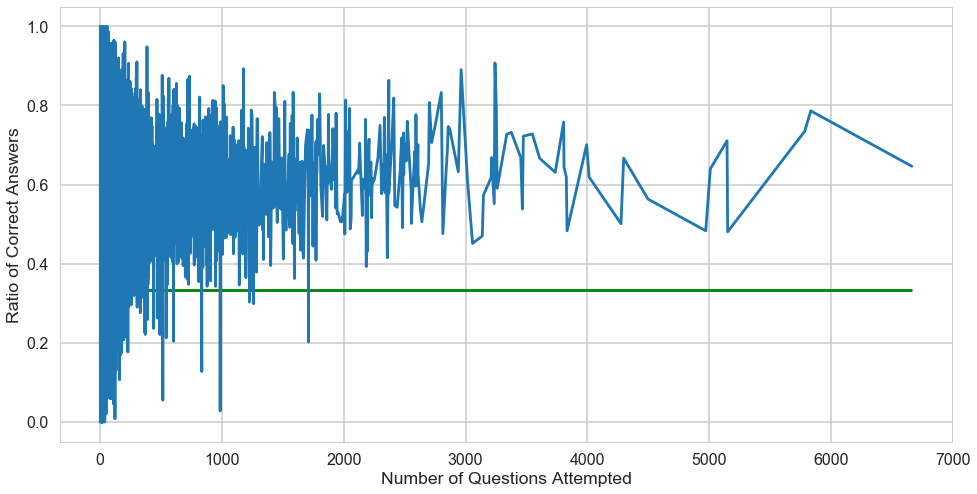

In [135]:
scores_by_num_questions = gmat_users.sort_values('num_questions')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_num_questions.num_questions, scores_by_num_questions.correct_ratio)
plt.hlines(xmin=0, xmax=scores_by_num_questions.num_questions.max(), y=scores_by_num_questions.correct_ratio.mean(), color='green')
plt.xlabel('Number of Questions Attempted')
plt.ylabel('Ratio of Correct Answers');

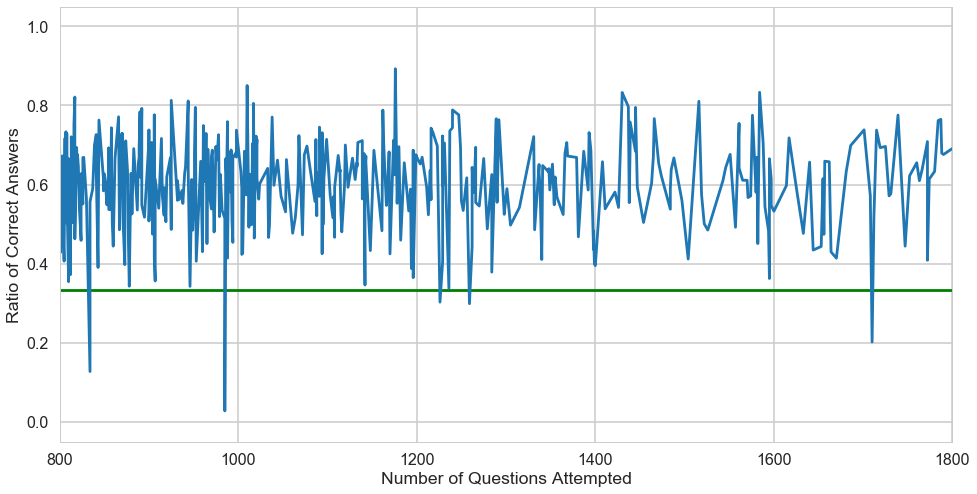

In [136]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_num_questions.num_questions, scores_by_num_questions.correct_ratio)
plt.hlines(xmin=0, xmax=scores_by_num_questions.num_questions.max(), y=scores_by_num_questions.correct_ratio.mean(), color='green')
plt.xlabel('Number of Questions Attempted')
plt.ylabel('Ratio of Correct Answers')
plt.xlim(800, 1800);

Except for one, users attempting at least 1000 questions consistently perform above the average ratio of correct answers.

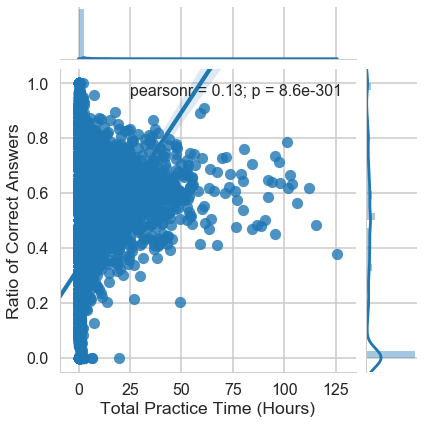

In [138]:
sns.jointplot(gmat_users['total_practice']/np.timedelta64(1, 'h'), gmat_users.correct_ratio, kind='reg', size=6)
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers')
plt.ylim(-0.05, 1.05);

In [139]:
gmat_users[gmat_users['total_practice']/np.timedelta64(1, 'h') > 100]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
12380,2405,1204,3609,0,0,0.666390,4 days 06:52:05,00:01:42.611526,0,0
67095,486,798,1284,0,0,0.378505,5 days 05:37:33,00:05:52.221962,0,0
103201,2485,1530,4015,0,1,0.618929,4 days 15:56:51,00:01:40.376338,0,0
115950,2402,2571,4973,0,1,0.483008,4 days 19:08:53,00:01:23.356726,0,0
119351,4589,1247,5836,0,1,0.786326,4 days 05:26:10,00:01:02.571967,0,0
129114,2369,1459,3828,0,0,0.618861,4 days 05:49:40,00:01:35.762800,0,0
166331,2358,1379,3737,0,0,0.630987,4 days 07:50:43,00:01:40.038265,0,0
168669,2534,1965,4499,0,1,0.563236,4 days 10:13:03,00:01:24.992887,0,0


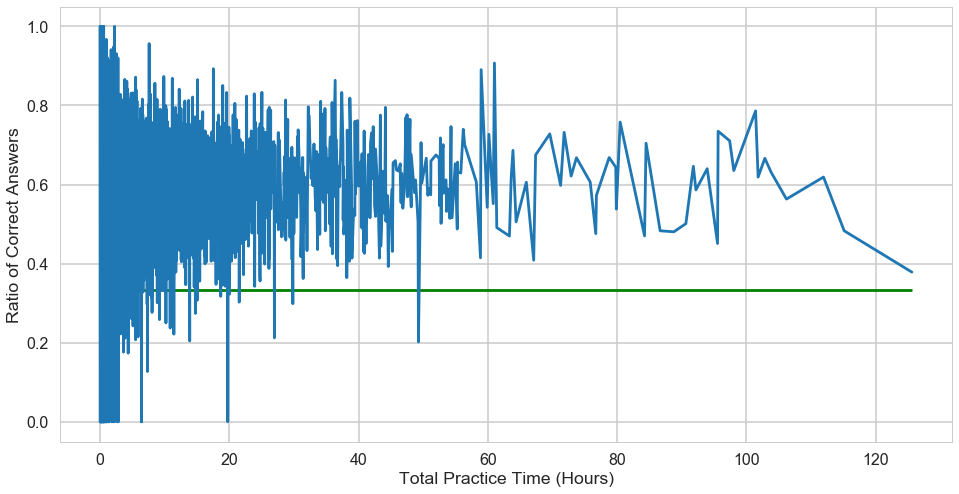

In [142]:
scores_by_total_practice = gmat_users.sort_values('total_practice')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_total_practice.total_practice/np.timedelta64(1, 'h'), scores_by_total_practice.correct_ratio)
plt.hlines(xmin=0, xmax=(scores_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=scores_by_total_practice.correct_ratio.mean(), color='green')
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers');

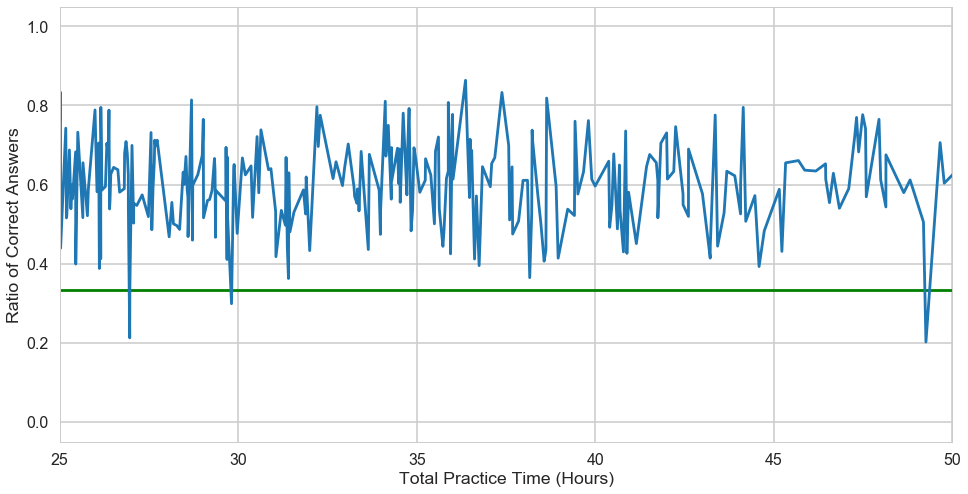

In [143]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_total_practice.total_practice/np.timedelta64(1, 'h'), scores_by_total_practice.correct_ratio)
plt.hlines(xmin=0, xmax=(scores_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=scores_by_total_practice.correct_ratio.mean(), color='green')
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers')
plt.xlim(25, 50);

Except for one, users practicing at least 30 hours consistently perform above the average ratio of correct answers.

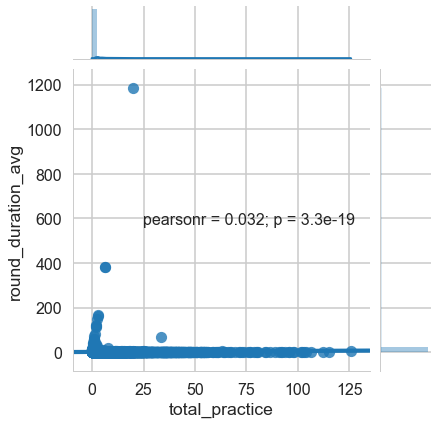

In [140]:
sns.jointplot(gmat_users['total_practice']/np.timedelta64(1, 'h'), gmat_users.round_duration_avg/np.timedelta64(1, 'm'), kind='reg', size=6);

In [141]:
gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 200]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
140745,0,1,1,1,0,0.0,19:44:07,19:44:07,1,0
173259,0,1,1,1,0,0.0,06:24:03,06:24:03,1,0
173399,0,1,1,1,0,0.0,06:23:14,06:23:14,1,0


In [144]:
df[df.user_id.isin(gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 200].index.values)]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts,outcome
321518,173399,2011-05-02 06:26:41,NaT,2011-05-02 12:49:55,2011-05-02 12:49:55,0,2548,gmat,4,9,14 55 77 161,0,7,1,06:23:14,0,1,1,1,0,0,0,incorrect
2537019,140745,2010-05-05 21:21:08,NaT,2010-05-06 17:05:15,2010-05-06 17:05:15,0,2512,gmat,5,0,28 49,0,4,31,19:44:07,0,1,1,1,0,0,0,incorrect
3802301,173259,2011-05-02 06:22:20,NaT,2011-05-02 12:46:23,2011-05-02 12:46:23,0,5167,gmat,5,14,224 228 233 246,0,7,1,06:24:03,0,1,1,1,0,0,0,incorrect


In [145]:
gmat[gmat.question_id == 2548][['correct', 'round_duration']].describe()

,correct,round_duration
count,4763.000000,4763
mean,0.843586,0 days 00:00:33.923157
std,0.363286,0 days 00:05:34.220973
min,0.000000,0 days 00:00:01
25%,1.000000,0 days 00:00:11
50%,1.000000,0 days 00:00:20
75%,1.000000,0 days 00:00:35
max,1.000000,0 days 06:23:14


In [146]:
gmat[gmat.question_id == 2548][categorical].describe()

,user_id,question_id,group_name,track_name,subtrack_name,question_type,game_type,num_players,fast,slow,prior_attempts,excessive_attempts,outcome,few,many,slow_avg,fast_avg
count,4763,4763,4763,4763,4763,4763,4763,4763,4763,4763,4763,4763,4763,4763,4763,4763,4763
unique,4508,1,1,1,1,1,8,7,2,2,8,1,2,2,2,2,2
top,8769,2548,gmat,4,9,0,7,1,0,0,0,0,correct,0,0,0,0
freq,8,4763,4763,4763,4763,4763,3621,4261,4563,4761,4508,4763,4018,4185,4734,4761,4745


In [147]:
gmat[gmat.question_id == 2512][['correct', 'round_duration']].describe()

,correct,round_duration
count,2549.000000,2549
mean,0.536289,0 days 00:01:50.213417
std,0.498779,0 days 00:23:34.683977
min,0.000000,0 days 00:00:01
25%,0.000000,0 days 00:00:48
50%,1.000000,0 days 00:01:14
75%,1.000000,0 days 00:01:45
max,1.000000,0 days 19:44:07


In [148]:
gmat[gmat.question_id == 2512][categorical].describe()

,user_id,question_id,group_name,track_name,subtrack_name,question_type,game_type,num_players,fast,slow,prior_attempts,excessive_attempts,outcome,few,many,slow_avg,fast_avg
count,2549,2549,2549,2549,2549,2549,2549,2549,2549,2549,2549,2549,2549,2549,2549,2549,2549
unique,2183,1,1,1,1,1,9,8,2,2,10,1,2,2,2,2,2
top,111935,2512,gmat,5,0,0,7,1,0,0,0,0,correct,0,0,0,0
freq,10,2549,2549,2549,2549,2549,1022,1961,2491,2543,2183,2549,1367,2413,2524,2544,2544


In [149]:
gmat[gmat.question_id == 5167][['correct', 'round_duration']].describe()

,correct,round_duration
count,3923.000000,3923
mean,0.581188,0 days 00:00:57.971705
std,0.493427,0 days 00:06:13.973291
min,0.000000,0 days 00:00:01
25%,0.000000,0 days 00:00:26
50%,1.000000,0 days 00:00:44
75%,1.000000,0 days 00:01:10
max,1.000000,0 days 06:24:03


In [150]:
gmat[gmat.question_id == 5167][categorical].describe()

,user_id,question_id,group_name,track_name,subtrack_name,question_type,game_type,num_players,fast,slow,prior_attempts,excessive_attempts,outcome,few,many,slow_avg,fast_avg
count,3923,3923,3923,3923,3923,3923,3923,3923,3923,3923,3923,3923,3923,3923,3923,3923,3923
unique,3786,1,1,1,1,1,8,7,2,2,5,1,2,2,2,2,2
top,115950,5167,gmat,5,14,0,7,1,0,0,0,0,correct,0,0,0,0
freq,5,3923,3923,3923,3923,3923,3450,3521,3815,3921,3786,3923,2280,3132,3898,3921,3904


There's nothing to indicate the questions above are difficult or unusual. The users above who never answered their one question attempt are dropped.

In [152]:
gmat = df2[df2['group_name'] == 'gmat']
gmat = gmat[~gmat.user_id.isin(gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 200].index.values)]
gmat, gmat_users = user_stats(gmat)

In [153]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    gmat[column] = gmat[column].astype('category')

# Convert ordered categorical variables:
gmat['num_players'] = pd.Categorical(gmat['num_players'], ordered=True)
gmat['prior_attempts'] = pd.Categorical(gmat['prior_attempts'], ordered=True)

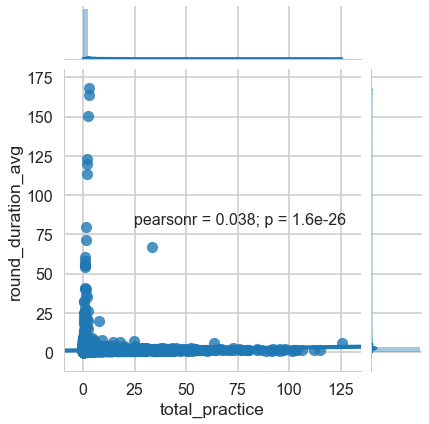

In [154]:
sns.jointplot(gmat_users['total_practice']/np.timedelta64(1, 'h'), gmat_users.round_duration_avg/np.timedelta64(1, 'm'), kind='reg', size=6);

In [155]:
gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 50]

,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
user_id,,,,,,,,,,
24563,0,1,1,1,0,0.000000,0 days 01:59:31,01:59:31,1,0
27818,0,1,1,1,0,0.000000,0 days 00:55:12,00:55:12,1,0
31019,0,1,1,1,0,0.000000,0 days 01:00:31,01:00:31,1,0
50897,0,1,1,1,0,0.000000,0 days 00:55:48,00:55:48,1,0
58616,0,1,1,1,0,0.000000,0 days 01:19:51,01:19:51,1,0
63880,0,1,1,1,0,0.000000,0 days 00:58:14,00:58:14,1,0
71027,0,1,1,1,0,0.000000,0 days 02:02:43,02:02:43,1,0
87808,0,1,1,1,0,0.000000,0 days 02:48:08,02:48:08,1,0
93901,0,1,1,1,0,0.000000,0 days 00:53:59,00:53:59,1,0


In [156]:
gmat[gmat.user_id.isin(gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 50].index.values)]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
5570,93901,2010-06-13 19:18:56,NaT,2010-06-13 20:12:55,2010-06-13 20:12:55,0,2249,gmat,4,1,4 14 52 55 77 117 262,0,7,1,00:53:59,0,1,0,0,incorrect,0,1,1,1,0,0.000000,0 days 00:53:59,00:53:59,1,0
189400,63880,2010-06-11 13:30:43,NaT,2010-06-11 14:28:57,2010-06-11 14:28:57,0,2249,gmat,4,1,4 14 52 55 77 117 262,0,7,1,00:58:14,0,1,0,0,incorrect,0,1,1,1,0,0.000000,0 days 00:58:14,00:58:14,1,0
512756,158715,2010-06-12 07:55:43,NaT,2010-06-12 10:39:29,2010-06-12 10:39:29,0,2249,gmat,4,1,4 14 52 55 77 117 262,0,7,1,02:43:46,0,1,0,0,incorrect,0,1,1,1,0,0.000000,0 days 02:43:46,02:43:46,1,0
590397,87808,2010-06-13 14:26:43,NaT,2010-06-13 17:14:51,2010-06-13 17:14:51,0,2249,gmat,4,1,4 14 52 55 77 117 262,0,7,1,02:48:08,0,1,0,0,incorrect,0,1,1,1,0,0.000000,0 days 02:48:08,02:48:08,1,0
680504,117421,2010-04-24 15:03:57,NaT,2010-04-24 16:15:30,2010-04-24 16:15:30,0,4177,gmat,5,11,189 207,0,7,8,01:11:33,0,1,0,0,incorrect,0,1,1,1,0,0.000000,0 days 01:11:33,01:11:33,1,0
969510,97268,2010-06-13 13:59:21,NaT,2010-06-13 16:29:42,2010-06-13 16:29:42,0,2249,gmat,4,1,4 14 52 55 77 117 262,0,7,1,02:30:21,0,1,0,0,incorrect,0,1,1,1,0,0.000000,0 days 02:30:21,02:30:21,1,0
1315182,31019,2009-01-12 09:23:56,NaT,2009-01-12 10:24:27,2009-01-12 10:24:27,0,1023,gmat,4,9,14 160 161,0,7,1,01:00:31,0,1,0,0,incorrect,0,1,1,1,0,0.000000,0 days 01:00:31,01:00:31,1,0
1441482,124845,2010-06-13 07:47:15,NaT,2010-06-13 09:40:44,2010-06-13 09:40:44,0,2249,gmat,4,1,4 14 52 55 77 117 262,0,7,1,01:53:29,0,1,0,0,incorrect,0,1,1,1,0,0.000000,0 days 01:53:29,01:53:29,1,0
1607184,58616,2010-06-14 05:44:29,NaT,2010-06-14 07:04:20,2010-06-14 07:04:20,0,2249,gmat,4,1,4 14 52 55 77 117 262,0,7,1,01:19:51,0,1,0,0,incorrect,0,1,1,1,0,0.000000,0 days 01:19:51,01:19:51,1,0
1614169,24563,2010-06-13 07:55:39,NaT,2010-06-13 09:55:10,2010-06-13 09:55:10,0,2249,gmat,4,1,4 14 52 55 77 117 262,0,7,1,01:59:31,0,1,0,0,incorrect,0,1,1,1,0,0.000000,0 days 01:59:31,01:59:31,1,0


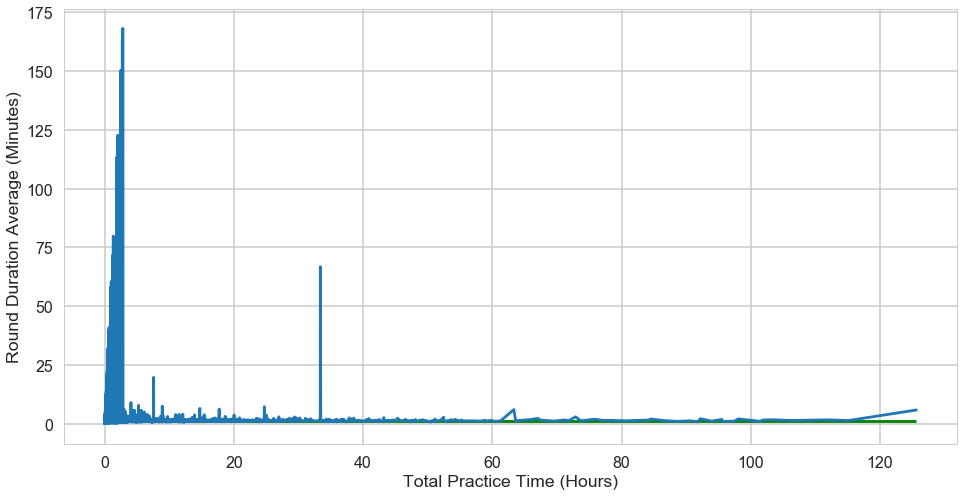

In [158]:
round_by_total_practice = gmat_users.sort_values('total_practice')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(round_by_total_practice.total_practice/np.timedelta64(1, 'h'), round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm'))
plt.hlines(xmin=0, xmax=(round_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=(round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm')).mean(), color='green')
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Minutes)');

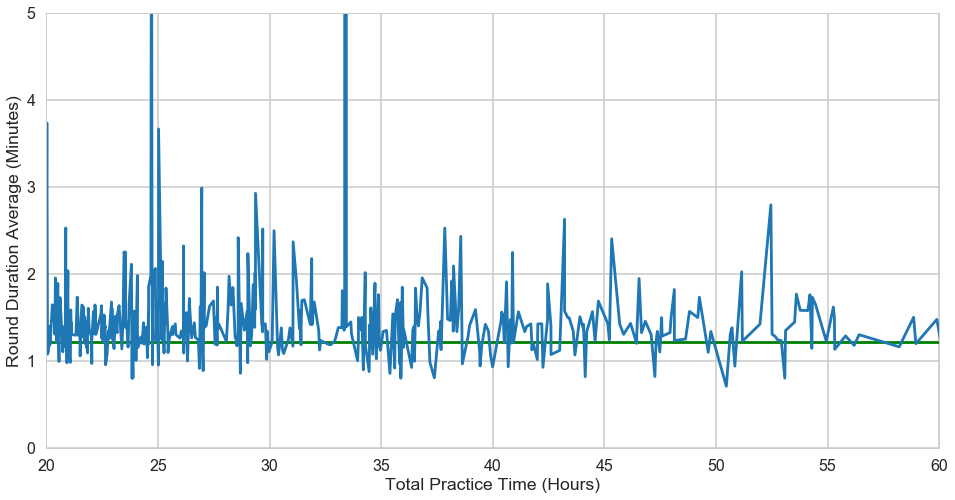

In [167]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(round_by_total_practice.total_practice/np.timedelta64(1, 'h'), round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm'))
plt.hlines(xmin=0, xmax=(round_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=(round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm')).mean(), color='green')
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Minutes)')
plt.ylim(0, 5), plt.xlim(20, 60);

In [165]:
df[df.user_id == 124145]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,num_questions,few,many,prior_attempts,excessive_attempts,outcome
3392444,124145,2010-03-21 16:34:44,2010-03-21 16:35:41,2010-03-21 16:35:45,2010-03-21 16:35:41,1,1775,gmat,4,1,4 52 135 262,0,7,2,00:00:57,0,0,30,0,0,0,0,correct
3392445,124145,2010-03-21 17:20:44,2010-03-21 17:21:17,2010-03-21 17:21:22,2010-03-21 17:21:17,1,4059,gmat,4,9,4 161 163 279,0,7,2,00:00:33,0,0,30,0,0,0,0,correct
3392446,124145,2010-03-21 17:21:33,2010-03-21 19:29:53,2010-03-21 19:29:55,2010-03-21 19:29:53,1,358,gmat,4,9,82 161 175 277 279,0,7,2,02:08:20,0,1,30,0,0,0,0,correct
3392447,124145,2010-03-21 19:29:56,2010-03-21 19:30:22,2010-03-21 19:30:25,2010-03-21 19:30:22,1,3102,gmat,4,9,82 149 161 175,0,7,2,00:00:26,0,0,30,0,0,0,0,correct
3392448,124145,2010-03-21 19:30:31,2010-03-21 19:30:39,2010-03-21 19:30:40,2010-03-21 19:30:39,1,530,gmat,4,9,4 161 205 279,0,7,2,00:00:08,0,0,30,0,0,0,0,correct
3392449,124145,2010-03-21 19:30:42,2010-03-21 19:30:49,2010-03-21 19:30:50,2010-03-21 19:30:49,1,5591,gmat,4,9,14 68 71 161,0,7,2,00:00:07,0,0,30,0,0,0,0,correct
3392450,124145,2010-03-21 19:30:51,2010-03-21 19:31:02,2010-03-21 19:31:03,2010-03-21 19:31:02,1,5013,gmat,4,9,14 67 77 161,0,7,2,00:00:11,0,0,30,0,0,0,0,correct
3392451,124145,2010-03-21 19:31:07,2010-03-21 19:31:32,2010-03-21 19:31:33,2010-03-21 19:31:32,1,121,gmat,4,9,4 68 71 161 251,0,7,2,00:00:25,0,0,30,0,0,0,0,correct
3392452,124145,2010-03-21 19:31:35,2010-03-21 19:31:55,2010-03-21 19:31:58,2010-03-21 19:31:55,1,1971,gmat,4,9,14 74 108 135 161,0,7,2,00:00:20,0,0,30,0,0,0,0,correct
3392453,124145,2010-03-21 19:32:06,2010-03-21 19:32:12,2010-03-21 19:32:15,2010-03-21 19:32:12,1,5383,gmat,4,9,4 161 279,0,7,2,00:00:06,0,0,30,0,0,0,0,correct


Aside from slow rounds, the pattern that stands out the most is that this user never participated in a round alone. Perhaps the other user(s) can be isolated for comparison. Aside from the outlier, `round_duration_avg` appears to be more consistent after 25 hours of practice.

## Question Data (GMAT)

In [169]:
len(gmat[gmat.slow == 1])

2970

In [170]:
gmat[gmat.slow == 1].answered_at.isnull().sum()

969

In [171]:
gmat[gmat.slow == 1].question_id.value_counts().head(15)

2249    25
1976    23
1463    21
2065    21
3352    21
5055    19
2091    17
5162    16
2596    15
538     14
3071    13
2770    13
2702    13
4148    12
319     12
Name: question_id, dtype: int64

In [172]:
gmat[gmat.question_id.isin(gmat[gmat.slow == 1].question_id.value_counts().head(15).index.values)].slow.value_counts()

0    30321
1      255
Name: slow, dtype: int64

Nearly a fourth of slow rounds were deactivated (never answered). The 15 questions with the most counts for slow rounds still had far more rounds that were not slow. It doesn't seem as though any particular question is slowing users down.

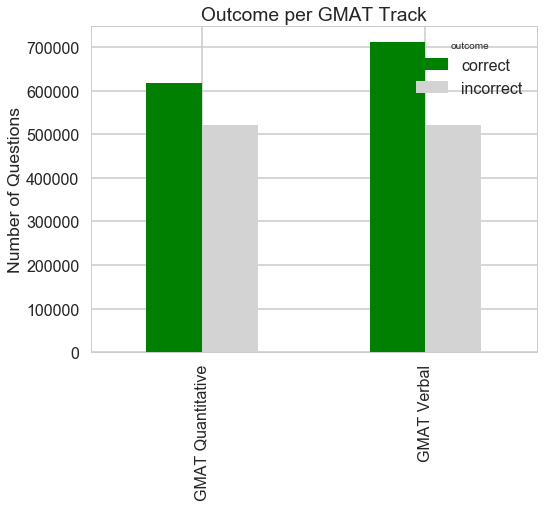

In [173]:
# Create bar plot for track_name distribution by 'outcome':
pd.crosstab(index=gmat.track_name, columns=[gmat.outcome]).plot(kind='bar', color=('green', 'lightgrey'), figsize=(8, 6))

# Create bar labels:
tracks = ('GMAT Quantitative', 'GMAT Verbal')
plt.xticks(np.arange(len(tracks)), tracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per GMAT Track');

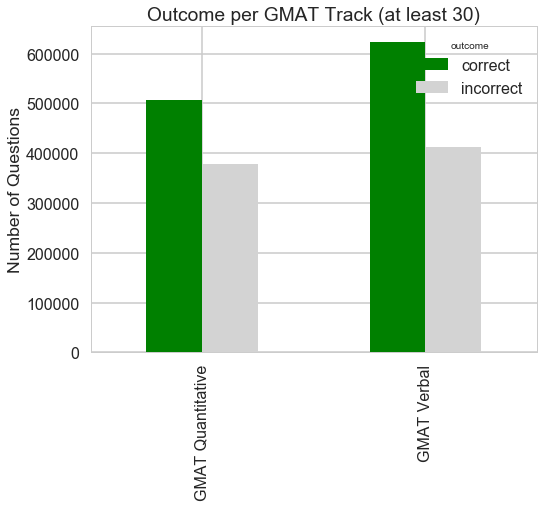

In [174]:
# Create bar plot for track_name distribution by 'outcome':
pd.crosstab(index=gmat_30.track_name, columns=[gmat_30.outcome]).plot(kind='bar', color=('green', 'lightgrey'), figsize=(8, 6))

# Create bar labels:
tracks = ('GMAT Quantitative', 'GMAT Verbal')
plt.xticks(np.arange(len(tracks)), tracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per GMAT Track (at least 30)');

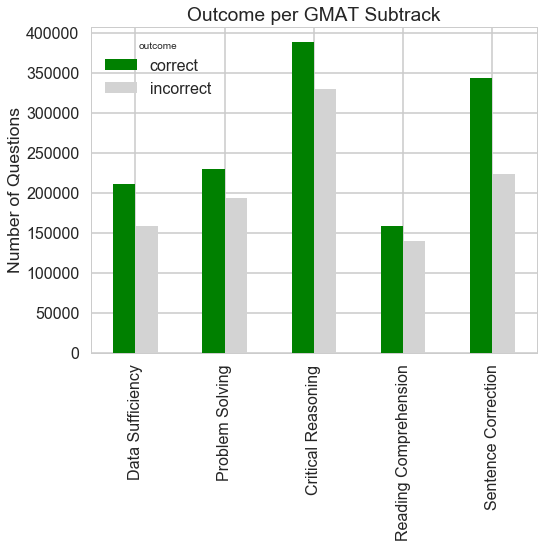

In [175]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=gmat.subtrack_name, columns=[gmat.outcome]).plot(kind='bar', color=('green', 'lightgrey'), figsize=(8, 6))

# Create bar labels:
subtracks = ('Data Sufficiency', 'Problem Solving', 'Critical Reasoning', 'Reading Comprehension', 'Sentence Correction')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per GMAT Subtrack');

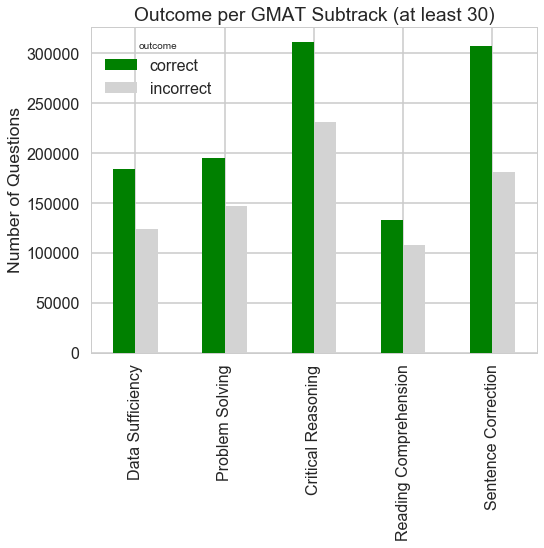

In [176]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=gmat_30.subtrack_name, columns=[gmat_30.outcome]).plot(kind='bar', color=('green', 'lightgrey'), figsize=(8, 6))

# Create bar labels:
subtracks = ('Data Sufficiency', 'Problem Solving', 'Critical Reasoning', 'Reading Comprehension', 'Sentence Correction')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per GMAT Subtrack (at least 30)');

In [178]:
# Save the clean dataframe to the interim data directory:
gmat.to_csv('../data/interim/clean_gmat.csv')

---
## SAT EDA

In [ ]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    sat[column] = sat[column].astype('category')

# Convert ordered categorical variables:
sat['num_players'] = pd.Categorical(sat['num_players'], ordered=True)
sat['prior_attempts'] = pd.Categorical(sat['prior_attempts'], ordered=True)

In [ ]:
sat.head()

In [ ]:
print('Group name statistics associated with excessive prior attempts:')
sat[sat.excessive_attempts == 1].group_name.describe()

In [ ]:
print('Track name statistics associated with excessive prior attempts:')
sat[sat.excessive_attempts == 1].track_name.describe()

In [ ]:
print('Subtrack name statistics associated with excessive prior attempts:')
sat[sat.excessive_attempts == 1].subtrack_name.describe()

In [ ]:
print('Question type statistics associated with excessive prior attempts:')
sat[sat.excessive_attempts == 1].question_type.describe()

## All Observations (SAT)

In [ ]:
# Display statistics for numerical variables:
sat.describe()

In [ ]:
# Filter columns for category datatype and display the statistics:
categorical = sat.dtypes[sat.dtypes == 'category'].index
sat[categorical].describe()

### User Data (SAT)

In [ ]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat.num_questions, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat.num_questions, ax=histogram)

# Label axes and add title:
plt.xlabel('Number of Questions')
plt.title('Distribution of Observations per SAT User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [ ]:
sat_users.head()

In [ ]:
# Confirm the count of users:
print( ("Number of SAT Users: "), len(sat.user_id.value_counts()) )

In [ ]:
# Confirm the count of users:
print( ("Number of SAT Users: "), len(sat_users) )

In [ ]:
sat_users.describe()

In [ ]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat_users.correct_ratio, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat_users.correct_ratio, ax=histogram)

# Label axes and add title:
plt.title('Distribution of User Scores (SAT)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [ ]:
n = len(sat_users.correct_ratio)
M = np.mean(sat_users.correct_ratio)
s = np.std(sat_users.correct_ratio)

# Simulate a random sample with the same statistics and size of 10,000:
np.random.seed(42)
normal = np.random.normal(M, s, 10000)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Compute CDFs:
x_score, y_score = cdf(sat_users.correct_ratio)
x_norm, y_norm = cdf(normal)

# Plot both CDFs on the same plot:
fig = plt.plot(x_norm, y_norm)
fig = plt.plot(x_score, y_score, marker='.', linestyle='none')

# Label axes and add legend and a title:
fig = plt.xlabel('User Correct Ratio')
fig = plt.ylabel('CDF')
fig = plt.legend(('Normal Distribution', 'Empirical Data'), loc='best')
fig = plt.title('Distribution of User Scores (SAT)');

In [ ]:
# Number of users with score == 0
print(('Number of SAT users with no correct answers:'), len(sat_users[sat_users.correct_ratio == 0])) 

In [ ]:
sat_users[(sat_users.correct_ratio == sat_users.correct_ratio.min()) & (sat_users.few == False)]

In [ ]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat_users.total_practice/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat_users.total_practice/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Total Practic Time per (SAT) User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [ ]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat_users.round_duration_avg/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat_users.round_duration_avg/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (SAT) User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [ ]:
sns.jointplot(sat_users.num_questions, sat_users.num_correct, kind='reg', size=8)
plt.xlabel('Questions Attempted (SAT)');

In [ ]:
sns.jointplot(sat_users['total_practice']/np.timedelta64(1, 's'), sat_users.num_correct, kind='reg', size=8)
plt.xlabel('Total Practice Time (SAT)');

In [ ]:
sns.jointplot(np.log(sat_users['total_practice']/np.timedelta64(1, 's')), np.log(sat_users['round_duration_avg']/np.timedelta64(1, 's')), kind='reg', size=8)
plt.ylabel('Round Duration Average')
plt.xlabel('Total Practice Time (SAT)');

### Question Data (SAT)

In [ ]:
# Get a view of tiered variables related to the act group:
sat_tracks = pd.crosstab(index=sat.outcome,columns=[sat.track_name, sat.subtrack_name])
sat_tracks

In [ ]:
# Create bar plot for track_name distribution by 'outcome':
pd.crosstab(index=sat.track_name, columns=[sat.outcome]).plot(kind='bar', color=('green', 'lightgrey'), figsize=(8, 6))

# Create bar labels:
tracks = ('SAT Math', 'SAT Reading', 'SAT Writing')
plt.xticks(np.arange(len(tracks)), tracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per SAT Track');

In [ ]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=sat.subtrack_name, columns=[sat.outcome]).plot(kind='bar', color=('green', 'lightgrey'), figsize=(8, 6))

# Create bar labels:
subtracks = ('Multiple Choice', 'Student Produced Response', 'Passage Based Reading', 'Sentence Completion', 'Identifying Sentence Errors', 'Improving Paragraphs', 'Improving Sentences')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per SAT Subtrack');

## Users Attempting at least 30 Questions (SAT)

In [ ]:
# Save and inspect a dataframe of observations for the ACT group only:
sat = df[df['group_name'] == 'sat']
sat_30 = sat.groupby('user_id').filter(lambda x: x['user_id'].count() >= 30)
sat_30, sat_users_30 = user_stats(sat_30)
sat_30.head()

In [ ]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    sat_30[column] = sat_30[column].astype('category')

# Convert ordered categorical variables:
sat_30['num_players'] = pd.Categorical(sat_30['num_players'], ordered=True)
sat_30['prior_attempts'] = pd.Categorical(sat_30['prior_attempts'], ordered=True)

### User Data (SAT $\geq$ 30 Questions)

In [ ]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat_30.num_questions, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat_30.num_questions, ax=histogram)

# Label axes and add title:
plt.xlabel('Number of Questions')
plt.title('Distribution of Observations per SAT User (at least 30)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [ ]:
sat_users_30.head()

In [ ]:
sat_users_30[sat_users_30.few == True]

In [ ]:
# Confirm the count of users:
print( ("Number of SAT Users: "), len(sat_30.user_id.value_counts()) )

In [ ]:
# Confirm the count of users:
print( ("Number of SAT Users: "), len(sat_users_30) )

In [ ]:
sat_users_30.describe()

In [ ]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat_users_30.correct_ratio, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat_users_30.correct_ratio, ax=histogram)

# Label axes and add title:
plt.title('Distribution of User Scores (SAT at least 30)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [ ]:
n = len(sat_users_30.correct_ratio)
M = np.mean(sat_users_30.correct_ratio)
s = np.std(sat_users_30.correct_ratio)

# Simulate a random sample with the same statistics and size of 10,000:
np.random.seed(42)
normal = np.random.normal(M, s, 10000)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Compute CDFs:
x_score, y_score = cdf(sat_users_30.correct_ratio)
x_norm, y_norm = cdf(normal)

# Plot both CDFs on the same plot:
fig = plt.plot(x_norm, y_norm)
fig = plt.plot(x_score, y_score, marker='.', linestyle='none')

# Label axes and add legend and a title:
fig = plt.xlabel('User Correct Ratio')
fig = plt.ylabel('CDF')
fig = plt.legend(('Normal Distribution', 'Empirical Data'), loc='best')
fig = plt.title('Distribution of User Scores (SAT at least 30)');

In [ ]:
# Number of users with score == 0
print(('Number of SAT users with no correct answers:'), len(sat_users_30[sat_users_30.correct_ratio == 0])) 

In [ ]:
sat_users_30[sat_users_30.correct_ratio == sat_users_30.correct_ratio.min()]

In [ ]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat_users_30.total_practice/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat_users_30.total_practice/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Total Practic Time per (SAT) User (at least 30)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [ ]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (SAT) User (at least 30)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [ ]:
sns.jointplot(np.log(sat_users_30['total_practice']/np.timedelta64(1, 's')), np.log(sat_users_30['round_duration_avg']/np.timedelta64(1, 's')), kind='reg', size=8)
plt.ylabel('Round Duration Average')
plt.xlabel('Total Practice Time (SAT at least 30)');

### Question Data (SAT $\geq$ 30 Questions)

In [ ]:
# Get a view of tiered variables related to the act group:
sat_tracks = pd.crosstab(index=sat_30.outcome,columns=[sat_30.track_name, sat_30.subtrack_name])
sat_tracks

In [ ]:
# Create bar plot for track_name distribution by 'outcome':
pd.crosstab(index=sat_30.track_name, columns=[sat_30.outcome]).plot(kind='bar', color=('green', 'lightgrey'), figsize=(8, 6))

# Create bar labels:
tracks = ('SAT Math', 'SAT Reading', 'SAT Writing')
plt.xticks(np.arange(len(tracks)), tracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per SAT Track (at least 30)');

In [ ]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=sat_30.subtrack_name, columns=[sat_30.outcome]).plot(kind='bar', color=('green', 'lightgrey'), figsize=(8, 6))

# Create bar labels:
subtracks = ('Multiple Choice', 'Student Produced Response', 'Passage Based Reading', 'Sentence Completion', 'Identifying Sentence Errors', 'Improving Paragraphs', 'Improving Sentences')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per SAT Subtrack (at least 30)');

<a href='#top' id='summary'>back to menu</a>

---
## SAVE & SUMMARIZE

---
## [Machine Learning Analysis](http://nbviewer.jupyter.org/github/humburgc/academic_mastery_study/blob/master/notebooks/machine_learning_analysis.ipynb?flush_cache=true)

<br>